# __Spatial spectral analysis along a zonal transect across the atlantic__

* ```Purpose :``` This notebook performs spectral  analysis  in space on a 5-day SSH  time-lon transect (previously extracted from the OCCIPUT ensemble simulation).

* ```Author  :``` ```stephanie.leroux@ocean-next.fr```

* ```Date    :``` june 2018

* ```Notes   :```
    - This notebook reads data across many files. Make sure that ulimit is set to 1024 on your computer (especially on a Mac). From a terminal: ```ulimit -n 1024```.
    - You can use this notebook with the example data from there (opendap, 680 Mo): https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/CMEMS_GLO-HR/SX3_cmems/catalog.html 

# Load modules

In [1]:
## standart libraries
import os,sys
import numpy as np

from scipy.signal import argrelmax

# xarray
import xarray as xr

import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm

import cartopy.crs as ccrs

# wavelet (http://pycwt.readthedocs.io/en/latest/)
#import pycwt as wavelet
#from pycwt.helpers import find

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

%matplotlib inline 

# __ Input/Output files: parameters __

In [2]:
#--- input file to read
# input directory
basedir = "/mnt/meom/workdir/lerouste/OCCIPUT/ORCA025.L75/ORCA025.L75-OCCITENS/SX3_cmems/"
diri = basedir

# simulation name
CONFIGCASE ='ORCA025.L75-OCCITENS'
suffix = '5d_ssha.nc'
# variable
varna='ssh'

# section name (see map)
SXlist=['zSX3']
# min max longitude along which compute the spectral analysis
SXlonmin = -76.
SXlonmax = -25
  
    
# ---Plot output
pltty='.png'
dpifig=300

# figs are first saved  locally on the github server
diro = "/home/lerouste/FIGS/"

# __Define some plot functions__

In [3]:
def levelslog10(power, dtmin='auto',dtmax='auto'):
    """
    Power levels (plot colorscale)
    """
    if dtmax=='auto':
        dtmax = power.max()
    if dtmin=='auto':
        dtmin = power.min()
    lev = []
    for i in range(int(np.log10(dtmax / dtmin))):
        dtmin = dtmin * 2
        lev.append(dtmin)
    return lev


def fxplots(avesp, prefix,date1,date2,vmin,vmax,inc,xmin,xmax, diro='./',namo='test.png',dpifig=200):    
    '''
    This function aims to plot the time-wavenumber diagram from the spectral data previously computed with xfft.psd().
    It generates 6 plots: for the entire time period and for a zoom in time, and for each of these 2 options, the plot is made
    from the initial frequency (5-day) and from resampling to 3Month and 1 year averages.
    Parameters:
    * avesp: spectral data to plot (from xscale package: xfft.psd() )
    * xmin, xmax:  x-axis limits: (must be power exponents of 10 : xaxis from 10 ** xmin to x ** xmax )
    * prefix: prefix for plot name
    * date1, date2: dates of the 'zoom' in time.
    * vmin, vmax, inc: shading min,max, increment.
    '''
    
    # will make a plot for each of those 3 temporal resolutions (5d is the input frequency, 3M and 1Y will require resampling (averaging) ) 
    listsamp=('5d','3M', '1Y')


    #-----------------------------------
    # loop on the different options and make the plots:

    for typlo in listsamp:  # plot either 5-d data (original res) or resample to 1M, 3M, 1Y, whatever.

        for zoom in (True, False):

                namo = prefix+SXloc+'_'+varna


                if typlo=='5d':
                    avespPLT = avesp
                else:
                    avespPLT = avesp.resample(time_counter=typlo).mean(dim='time_counter')  #.isel(time_counter=slice(0,10))

                namo = namo+typlo

                # create fig
                fig = plt.figure(figsize=(8, 8), dpi=dpifig,facecolor='white')
                ax2 =  plt.gca()  

                # read frequencies and drop 0
                freqs = avespPLT[avespPLT.dims[1]]
                freqs = freqs.where(freqs != 0.,drop=True)
                X=freqs 

                # read spectral data and drop 0 frequency
                avespPLT = avespPLT.where(freqs != 0,drop=True)

                #if variance_preserving:
                avespPLT = freqs * avespPLT

                # log x-axis
                xlog = True

                # compute color levels 
                lev = levelslog10(avespPLT,'auto','auto')

                # colormap
                cmap=plt.cm.pink_r
                Colormap.set_under(cmap,color='w') 
                Colormap.set_over(cmap,color='k') 

                # if zoom on time
                if zoom:
                    namo = namo+"_zoom"
                    Y=avespPLT.time_counter.sel(time_counter=slice(date1,date2)).values
                    Z=avespPLT.sel(time_counter=slice(date1,date2)).transpose()
                else:
                    Y=avespPLT.time_counter.values[:]
                    Z=avespPLT.transpose()

                namo=namo+"_comesh"
                pc = plt.pcolormesh(X,Y,Z,cmap=cmap,vmin=vmin,vmax=vmax)

                # hatched zone out of resolution
                # lower limit (length of the section)- if needed (depends on choosen xmin)
                ax2.fill_betweenx(Y,10 ** xmin,freqs[1], facecolor="w", hatch="x", edgecolor="#F2F2F2", alpha=1.,linewidth=0.25, zorder=10)
                # upper limit (2 grid points 2*dx) - if needed (depends on choosen xmax)
                ax2.fill_betweenx(Y,freqs[-1],10 ** xmax, color=None, alpha=0.5, hatch='x',edgecolor='dimgrey',zorder=10)

                #---- Colorbar
                cbar = plt.colorbar(aspect=50)
                cbar.set_label('ePSD',size=12)
                cbar.ax.tick_params(labelsize=12) 

                #---- Y-Ticks labels in years     
                ax2.set_ylabel('Time', fontsize=12)
                ax2.yaxis.label.set_size(13)
                if zoom:
                    manyyears = mdates.YearLocator(1)   
                    years = mdates.YearLocator(1)   
                    #months = mdates.MonthLocator()  
                else:
                    manyyears = mdates.YearLocator(5)   
                    years = mdates.YearLocator(1)   
                    #months = mdates.MonthLocator()  
                ax2.yaxis.set_major_locator(manyyears)
                ax2.yaxis.set_minor_locator(years)

                #---- X-Ticks 
                ax2.set_xscale('log', nonposx='clip')
                ax2.set_xlabel('space wave number (1/km)', fontsize=12)
                ax2.xaxis.label.set_size(13)
                ax2.set_xlim(10 ** xmin, 10 ** xmax)\

                #---- Second axis with spatial wave lengths 
                twiny = ax2.twiny()

                twiny.set_xscale('log', nonposx='clip')
                twiny.set_xlim(10 ** xmin, 10 ** xmax)

                # major ticks
                new_major_ticks = 10 ** np.arange(xmin+1 , xmax, 1.)
                new_major_ticklabels = 1. / new_major_ticks
                new_major_ticklabels = ["%.0f" % i for i in new_major_ticklabels]

                twiny.set_xticks(new_major_ticks)
                twiny.set_xticklabels(new_major_ticklabels, rotation=60, fontsize=12)

                # minor ticks
                A = np.arange(2, 10, 2)[np.newaxis]
                B = 10 ** (np.arange(-xmax, -xmin, 1)[np.newaxis])
                C = np.dot(B.transpose(), A)

                new_minor_ticklabels = C.flatten()
                new_minor_ticks = 1. / new_minor_ticklabels
                new_minor_ticklabels = ["%.0f" % i for i in new_minor_ticklabels]
                twiny.set_xticks(new_minor_ticks, minor=True)
                twiny.set_xticklabels(new_minor_ticklabels, minor=True, rotation=60,
                                      fontsize=12)
                twiny.set_xlabel('wave length (km)', fontsize=12)
                
                plt.show()
                
                # save fig
                fig.savefig(diro+namo, facecolor=fig.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
                plt.close(fig) 

# __Read data__

In [4]:
# SSH 5-d data read across many files

# read and concatenate all files in one array (all times, all ensemble members, all zonal sections)
count=0
# loop on sections (useful if several sections)
for SXNA in SXlist :
    count=count+1
    print(diri+SXNA+'.'+CONFIGCASE+'.???.'+suffix)
    # read across ensemble members and times
    SXtemp = xr.open_mfdataset(diri+SXNA+'.'+CONFIGCASE+'.???.'+suffix,concat_dim='e')[varna].assign_coords(SXloc=SXNA).expand_dims('SXloc')
    if (count==1):
        SXall =  SXtemp
    else:
        # concatenate across sections
        SXall = xr.concat((SXall, SXtemp),dim='SXloc')

/mnt/meom/workdir/lerouste/OCCIPUT/ORCA025.L75/ORCA025.L75-OCCITENS/SX3_cmems/zSX3.ORCA025.L75-OCCITENS.???.5d_ssha.nc


# __1. Intrinsic part of the signal__

## Take intrinsic part of the signal only (remove ensemble mean)

In [5]:
# remove ensemble mean
predat = SXall-SXall.mean(axis=1) 
predat

<xarray.DataArray 'ssh' (SXloc: 1, e: 50, time_counter: 4088, y: 1, x: 1442)>
dask.array<shape=(1, 50, 4088, 1, 1442), dtype=float32, chunksize=(1, 1, 4088, 1, 1442)>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1960-01-03T12:00:00 ...
  * SXloc         (SXloc) <U4 'zSX3'
Dimensions without coordinates: e, y, x

## Read longitude, dx and annual; cycle from other files

In [6]:
SXloc=SXlist[0]

# read longitude
nav_lon = xr.open_dataset(diri+SXloc+'.'+CONFIGCASE+'.001.'+suffix)['nav_lon']

# get indices for longitues min and max of the section to work with
ilon1 = np.where((nav_lon[0,:] >= SXlonmin) & (nav_lon[0,:] <= SXlonmax))[0][0]
ilon2 = np.where((nav_lon[0,:] >= SXlonmin) & (nav_lon[0,:] <= SXlonmax))[0][-1]


# select lon between ilonmin and ilonmax
lonselect=nav_lon[0,ilon1:ilon2]
lonselect

# read annual cycle file (previously computed via nces)
climato = xr.open_dataset(diri+'E_AC.5d_ssha.nc')[varna] 
#climato.plot()


# read dx from e3t:
e1t =  xr.open_dataset(basedir+SXloc+'.'+CONFIGCASE+'.mesh_e1e2e3.nc')['e1t']


## Select all data over the longitude range

In [7]:
# get corresponding data
dat = predat.sel(SXloc=SXloc,y=0,x=slice(ilon1,ilon2)).load()

# read dx from NEMO metric file (corresponding to the given section): "e1"
dx = e1t.sel(t=0,y=0,x=slice(ilon1,ilon2)).mean()  # in m

# convert in km
dx=dx*1e-3 

/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## FFT decomposition and Power Spectral Density computation
Using [Guillaume Serazin's xscale package](https://github.com/serazing/xscale)

In [8]:
#--- parameter:
# padding: the fft is performed on a window of length NPADDING*seglen 
# where seglen is the actual length of the data and padded with zeros on both ends
NPADDING = 2

In [9]:
# use GS's package to perform fft decomposition on the x dimension

seglen = (dat.x.size) 
foo_x_spectrum = xfft.fft(dat, dim='x', dx=dx.values, detrend='mean',nfft=seglen*NPADDING,tapering=True)
foo_x_spectrum

# compute psd from fft coeff and average over the ensemble dimension
# load data in order to be quicker in the following plot tasks
avesp  = xfft.psd(foo_x_spectrum).mean(dim='e').load()


## Plot the time-wavenumber diagram with different options

'''
This function aims to plot the time-wavenumber diagram from the spectral data previously computed with xfft.psd().
It generates 6 plots: for the entire time period and for a zoom in time, and for each of these 2 options, the plot is made
from the initial frequency (5-day) and from resampling to 3Month and 1 year averages.
Parameters:
* avesp: spectral data to plot (from xscale package: xfft.psd() )
* xmin, xmax:  x-axis limits: (must be power exponents of 10 : xaxis from 10 ** xmin to x ** xmax )
* prefix: prefix for plot name
* date1, date2: dates of the 'zoom' in time.
* vmin, vmax, inc: shading min,max, increment.
'''

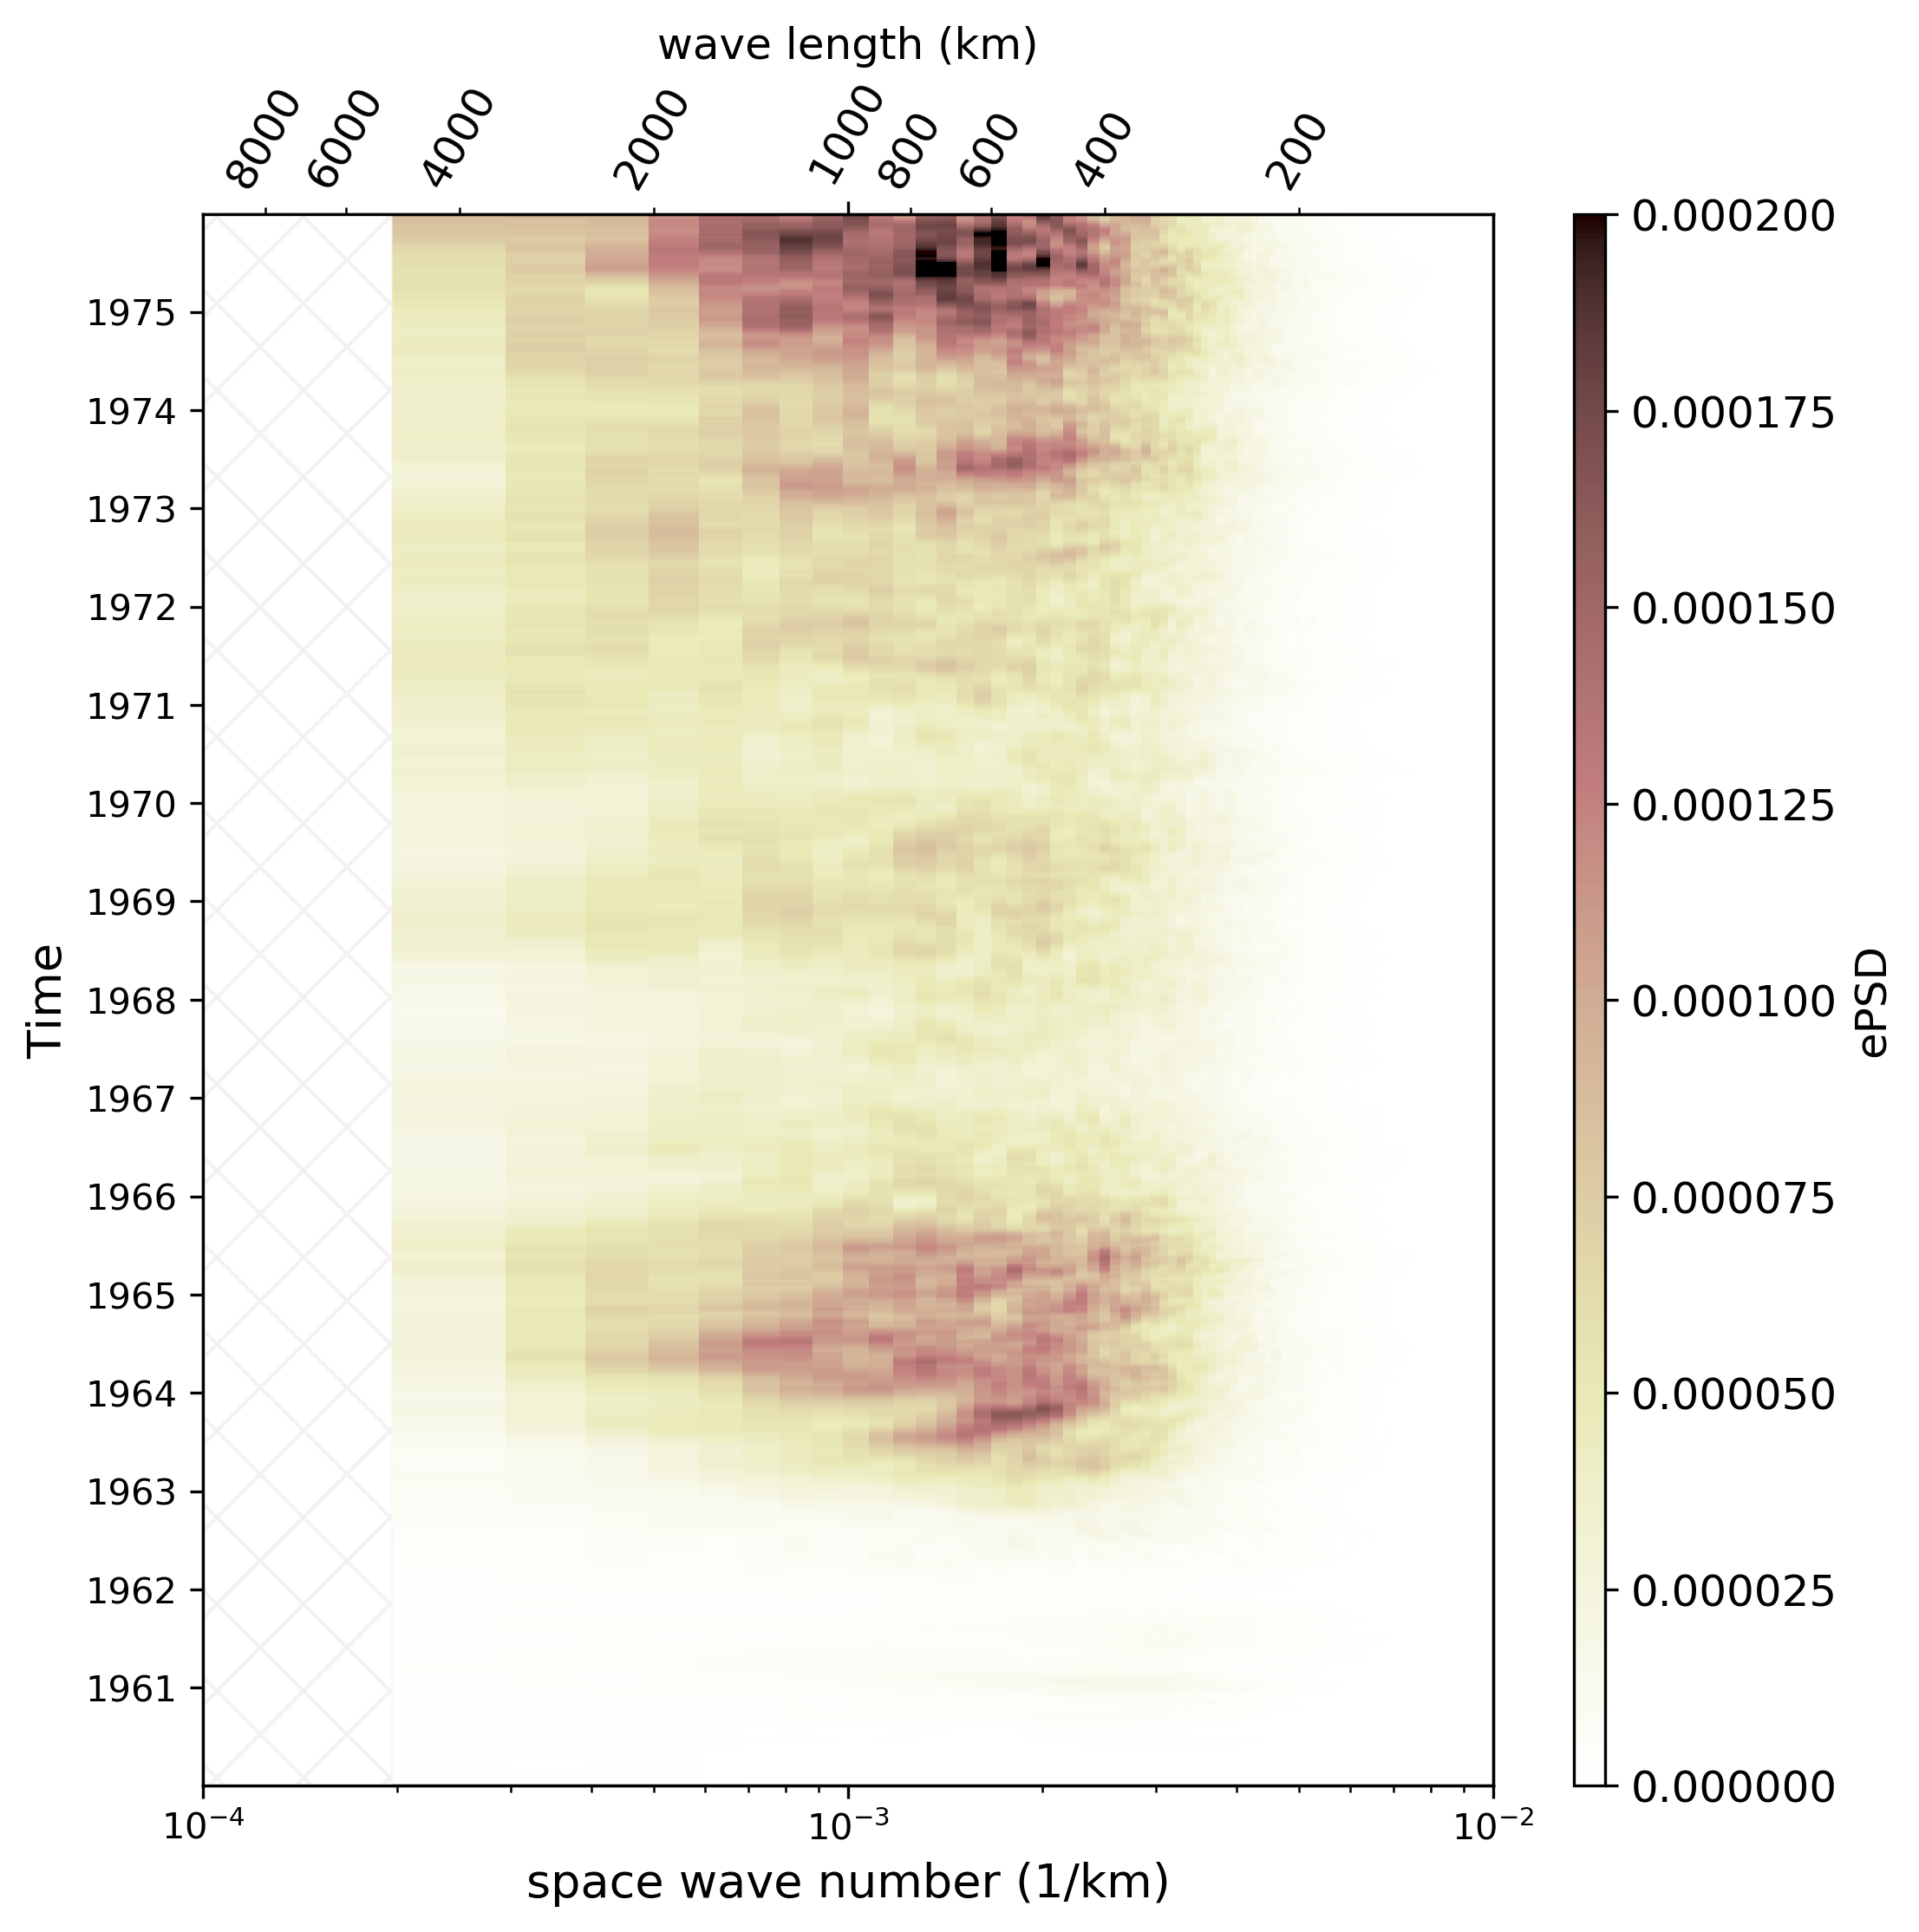

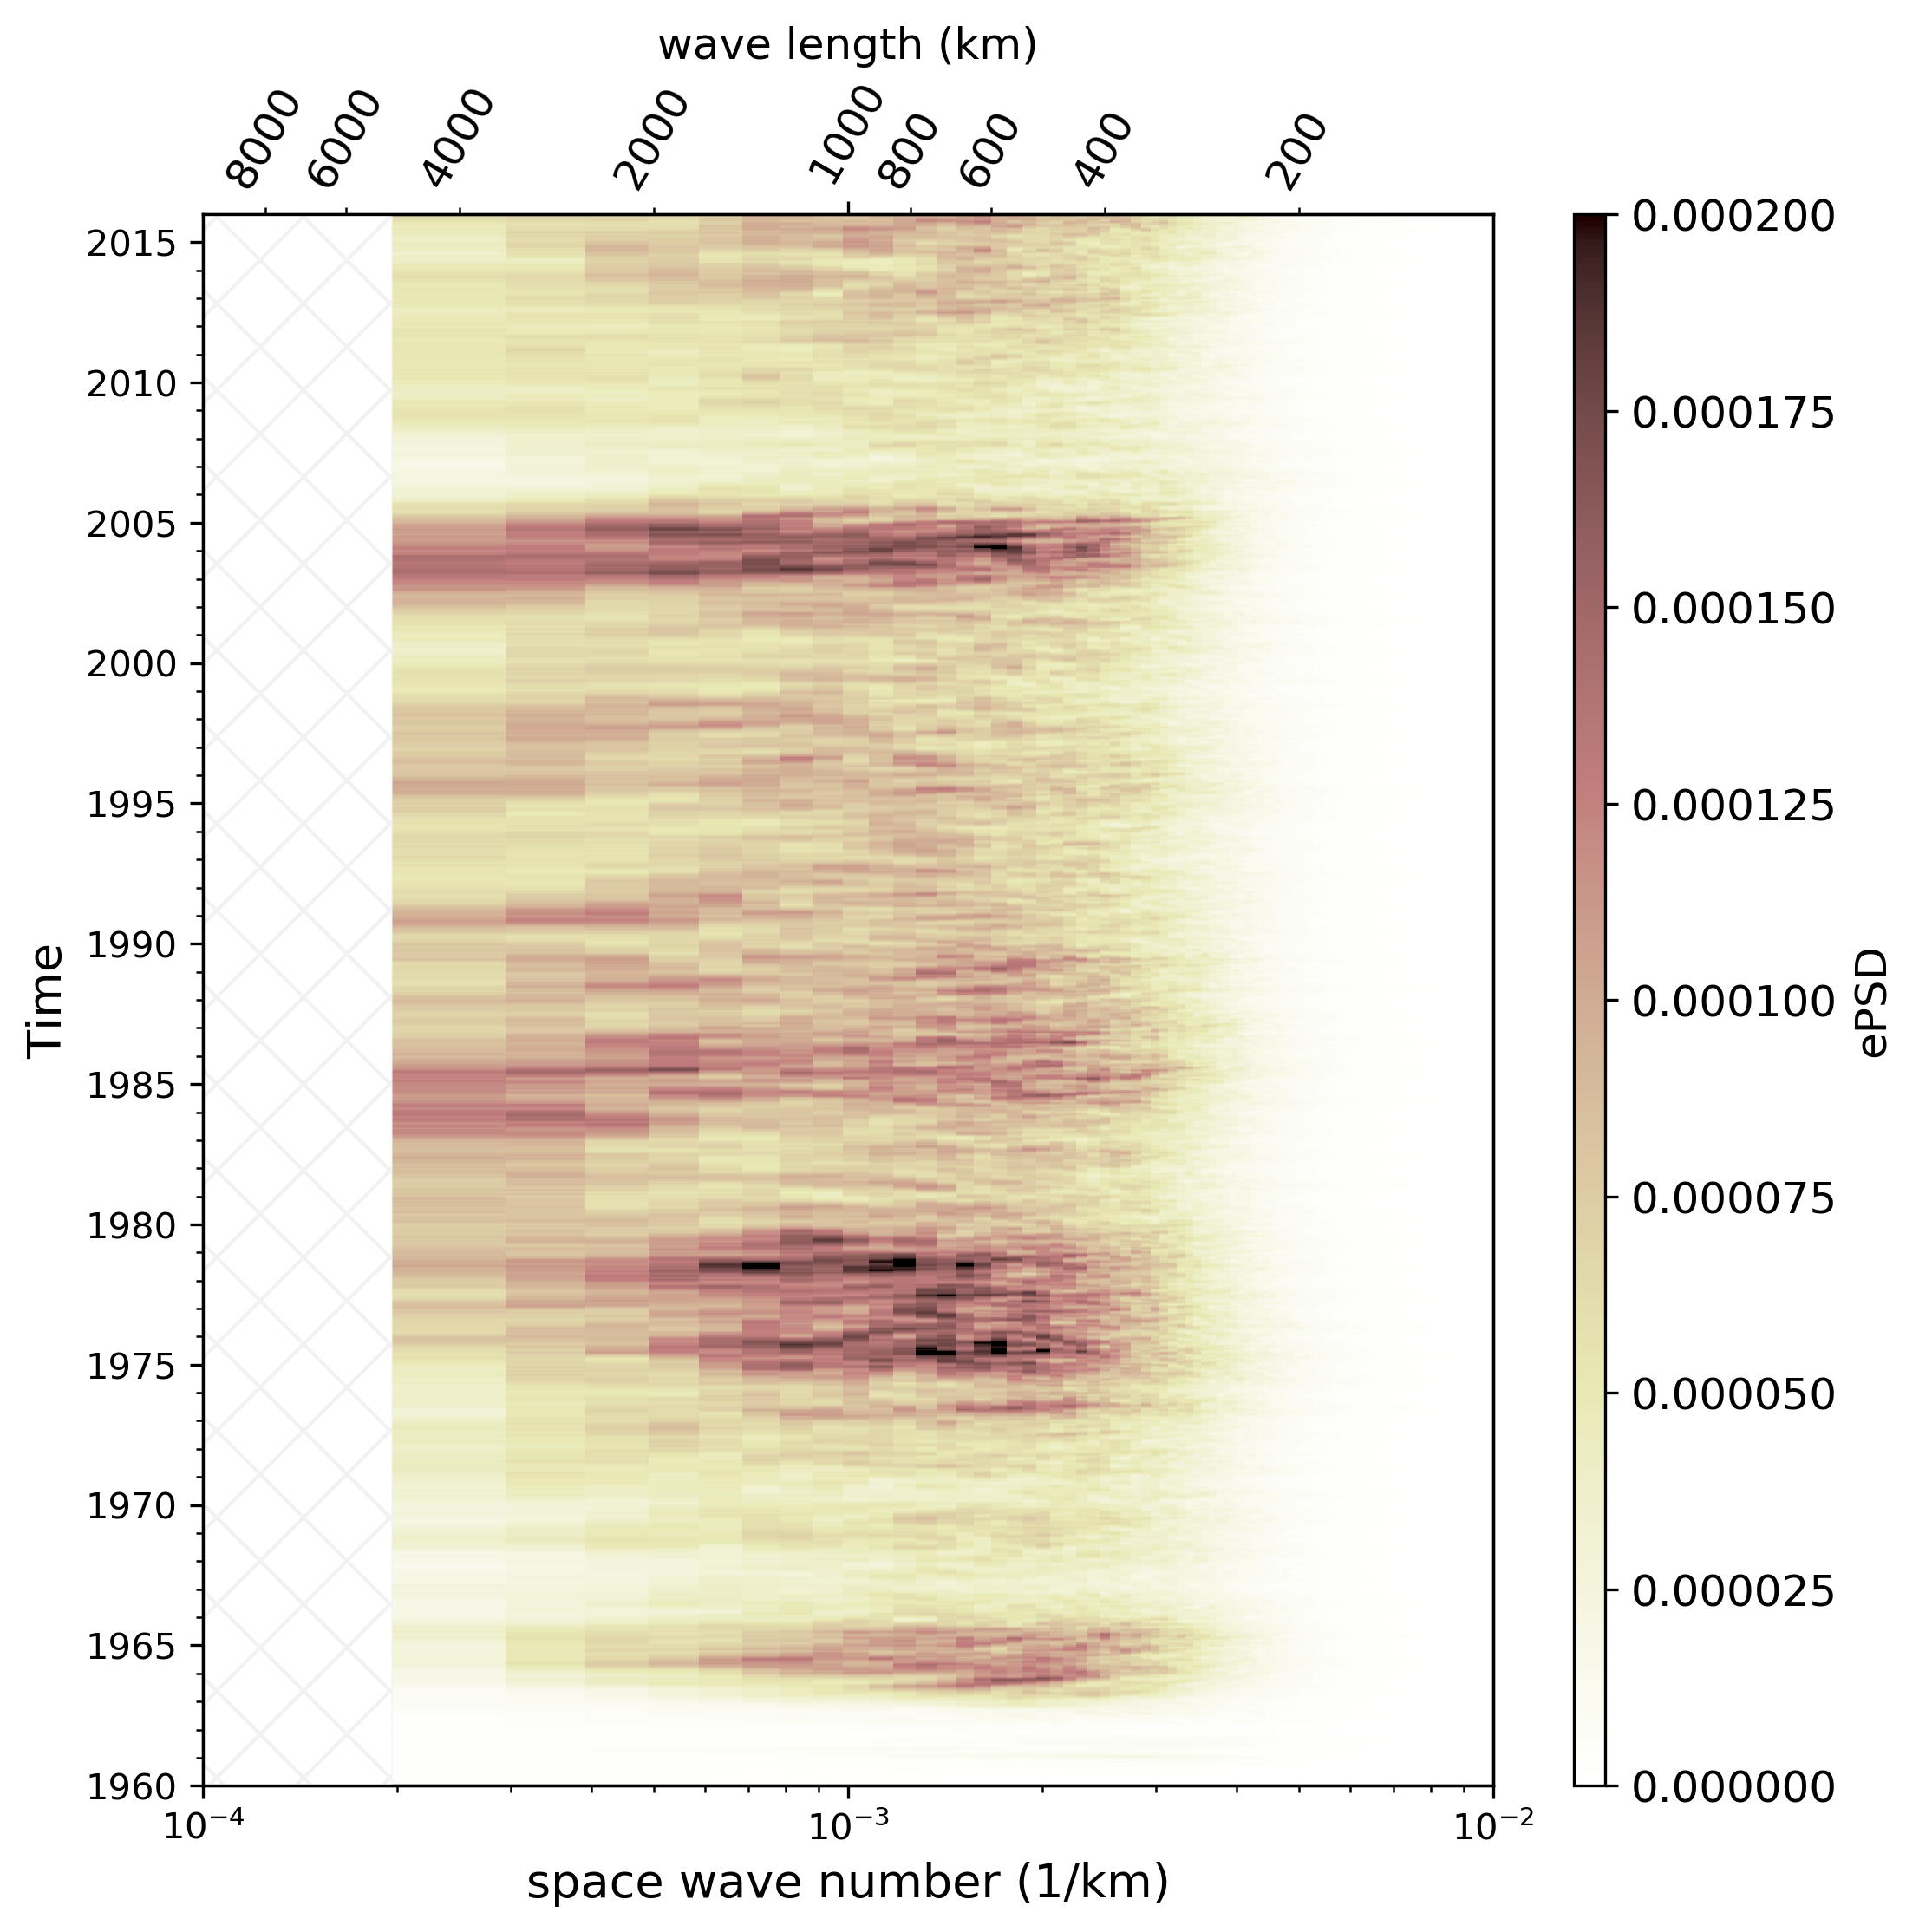

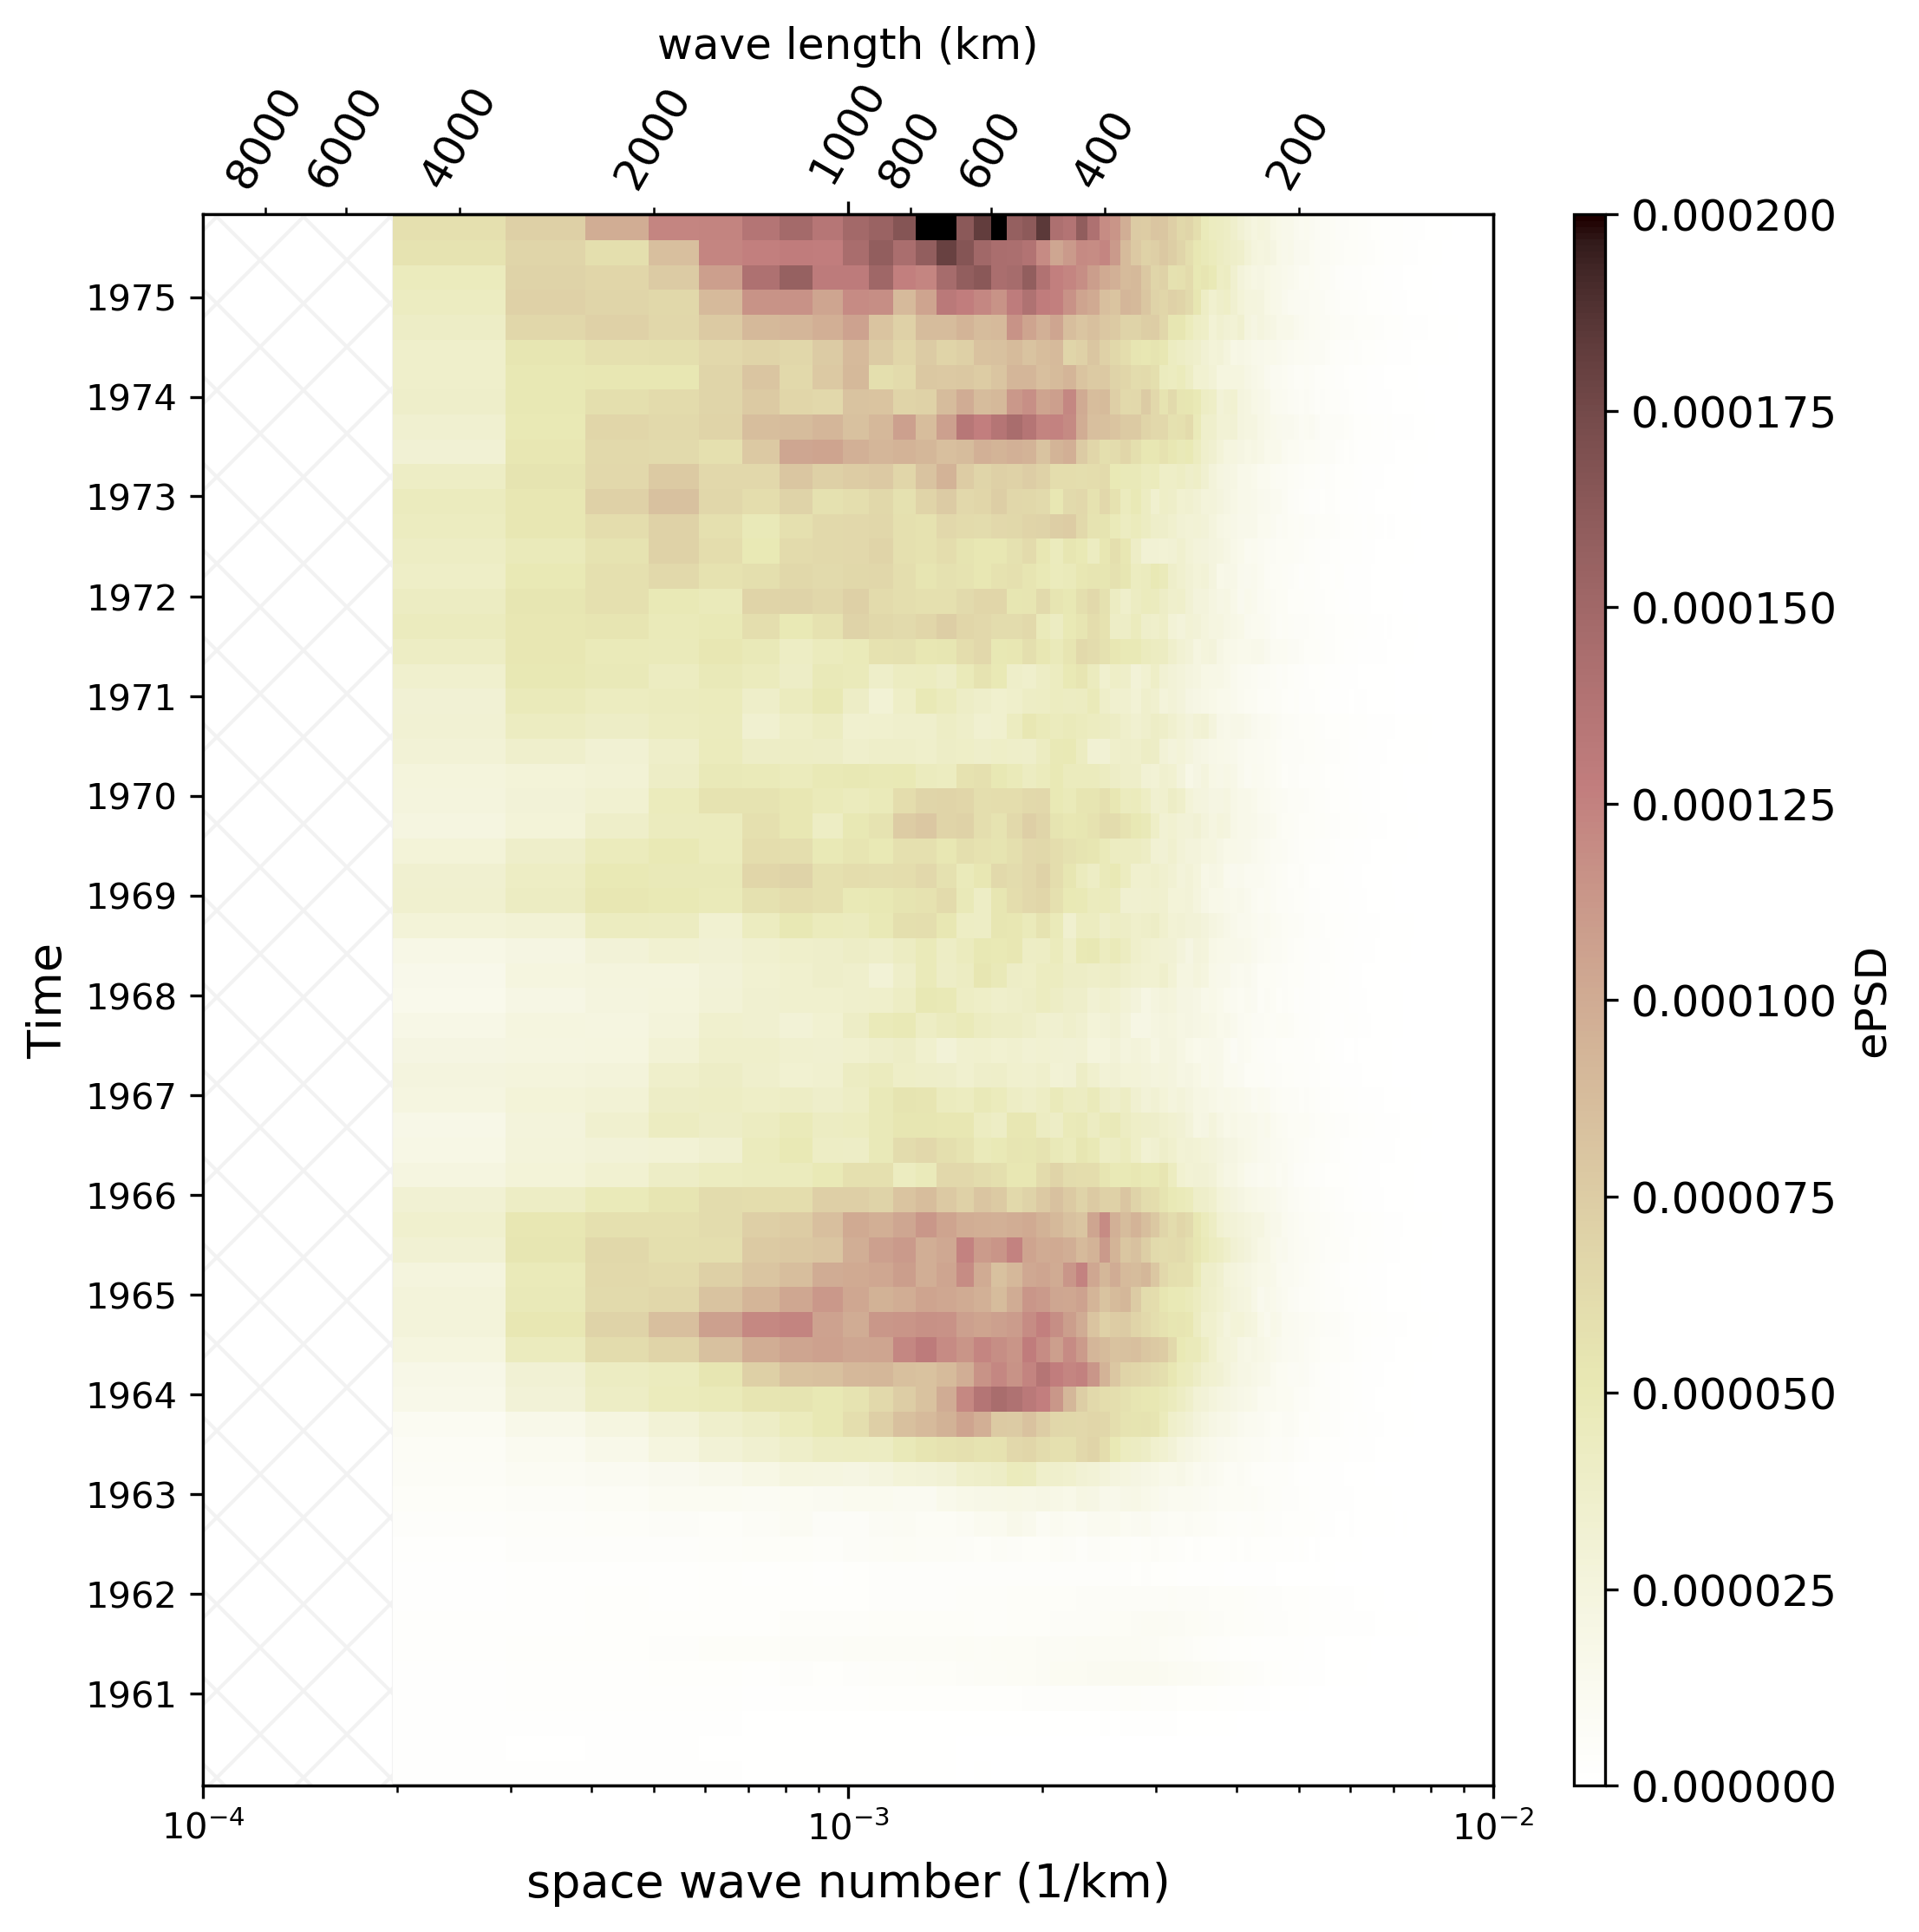

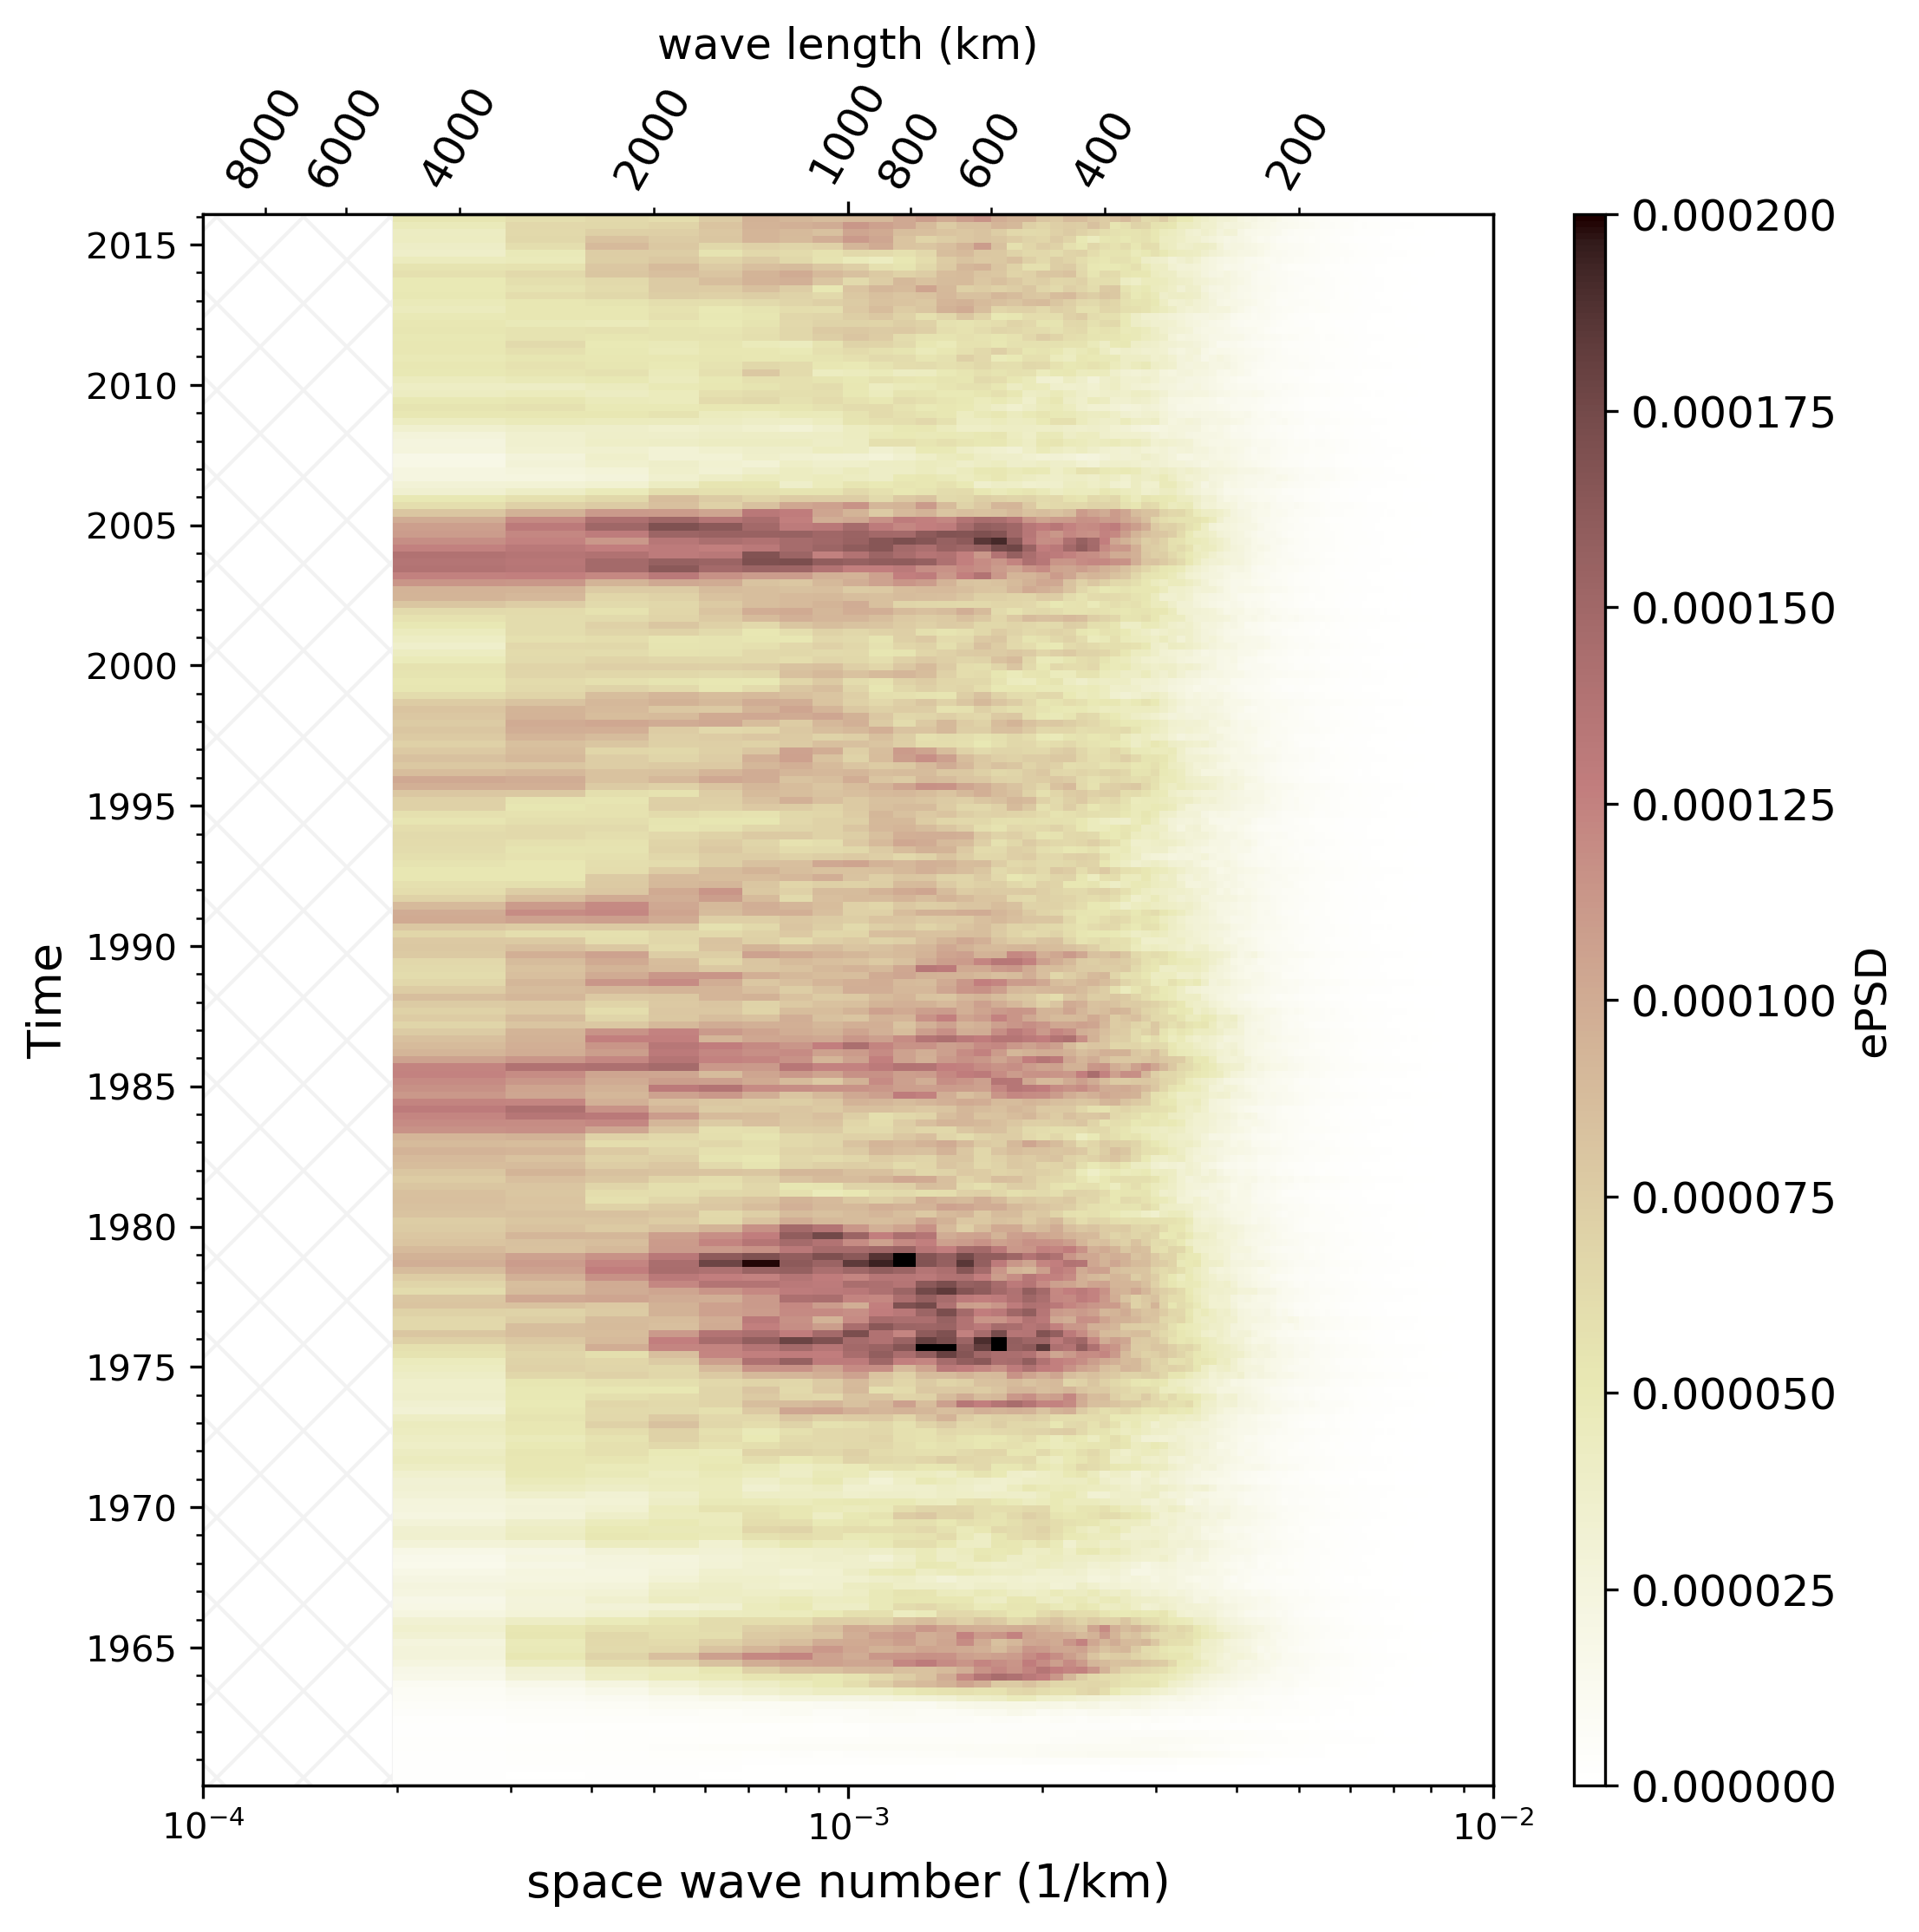

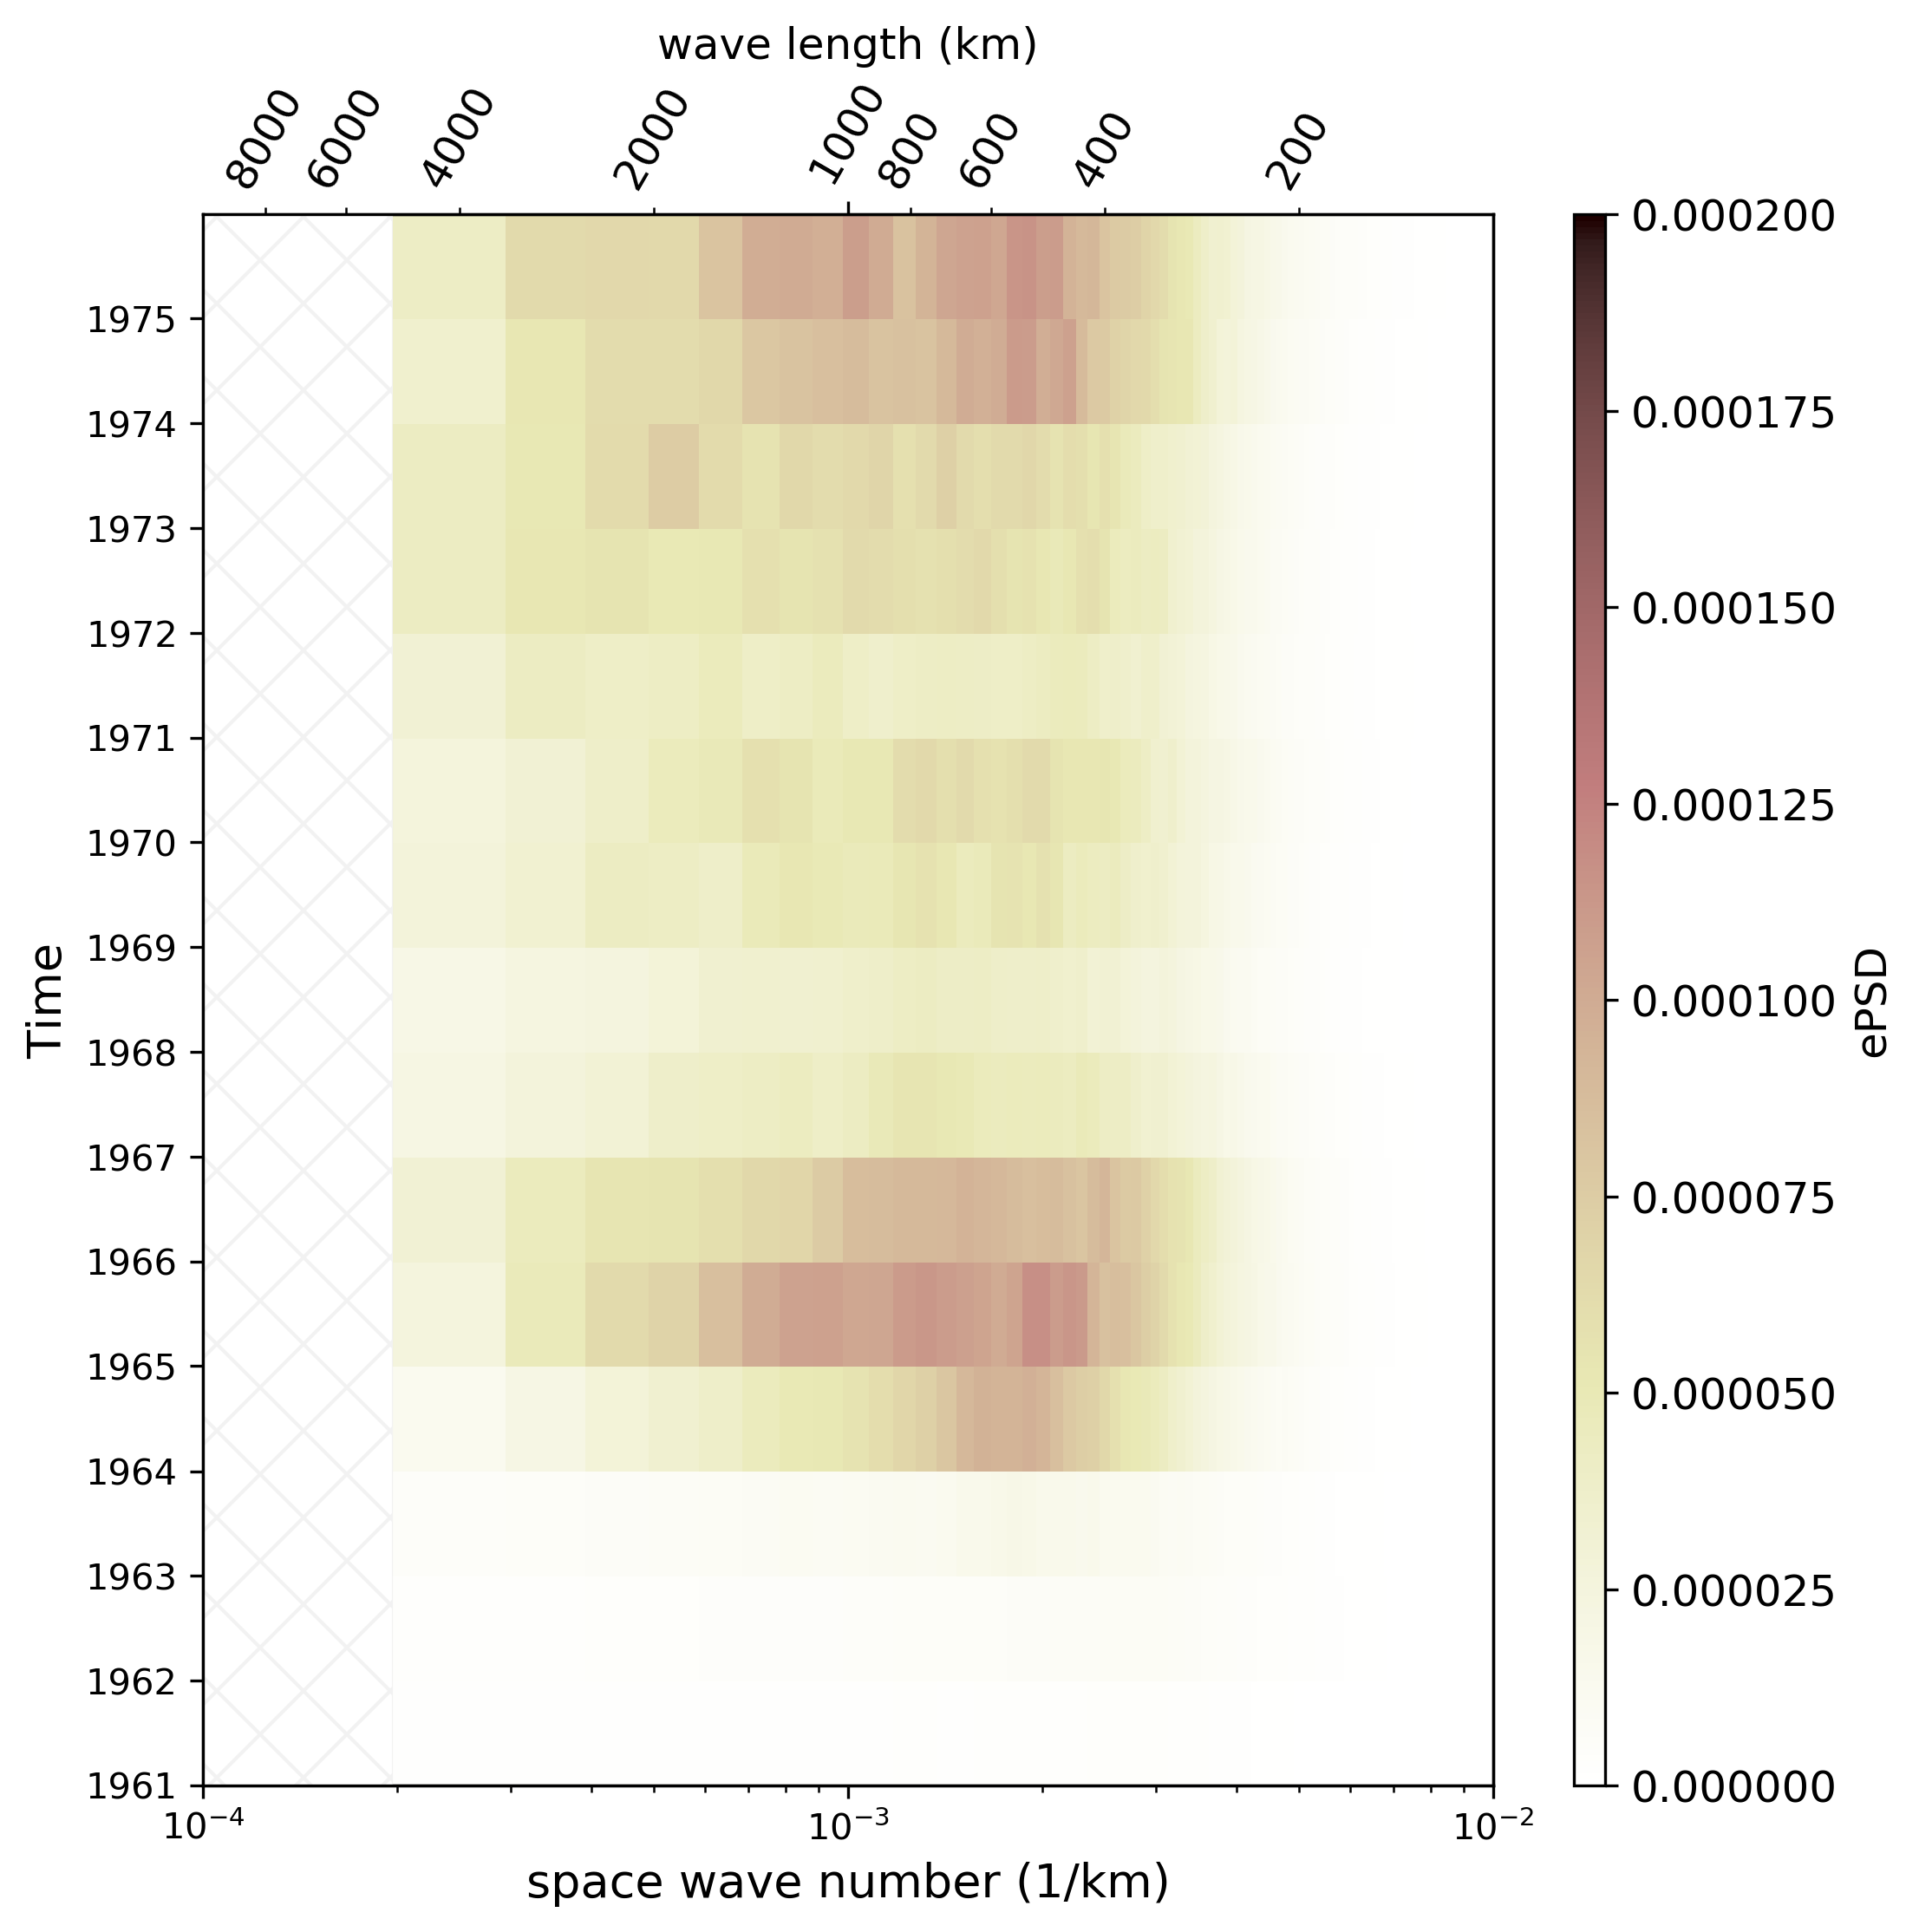

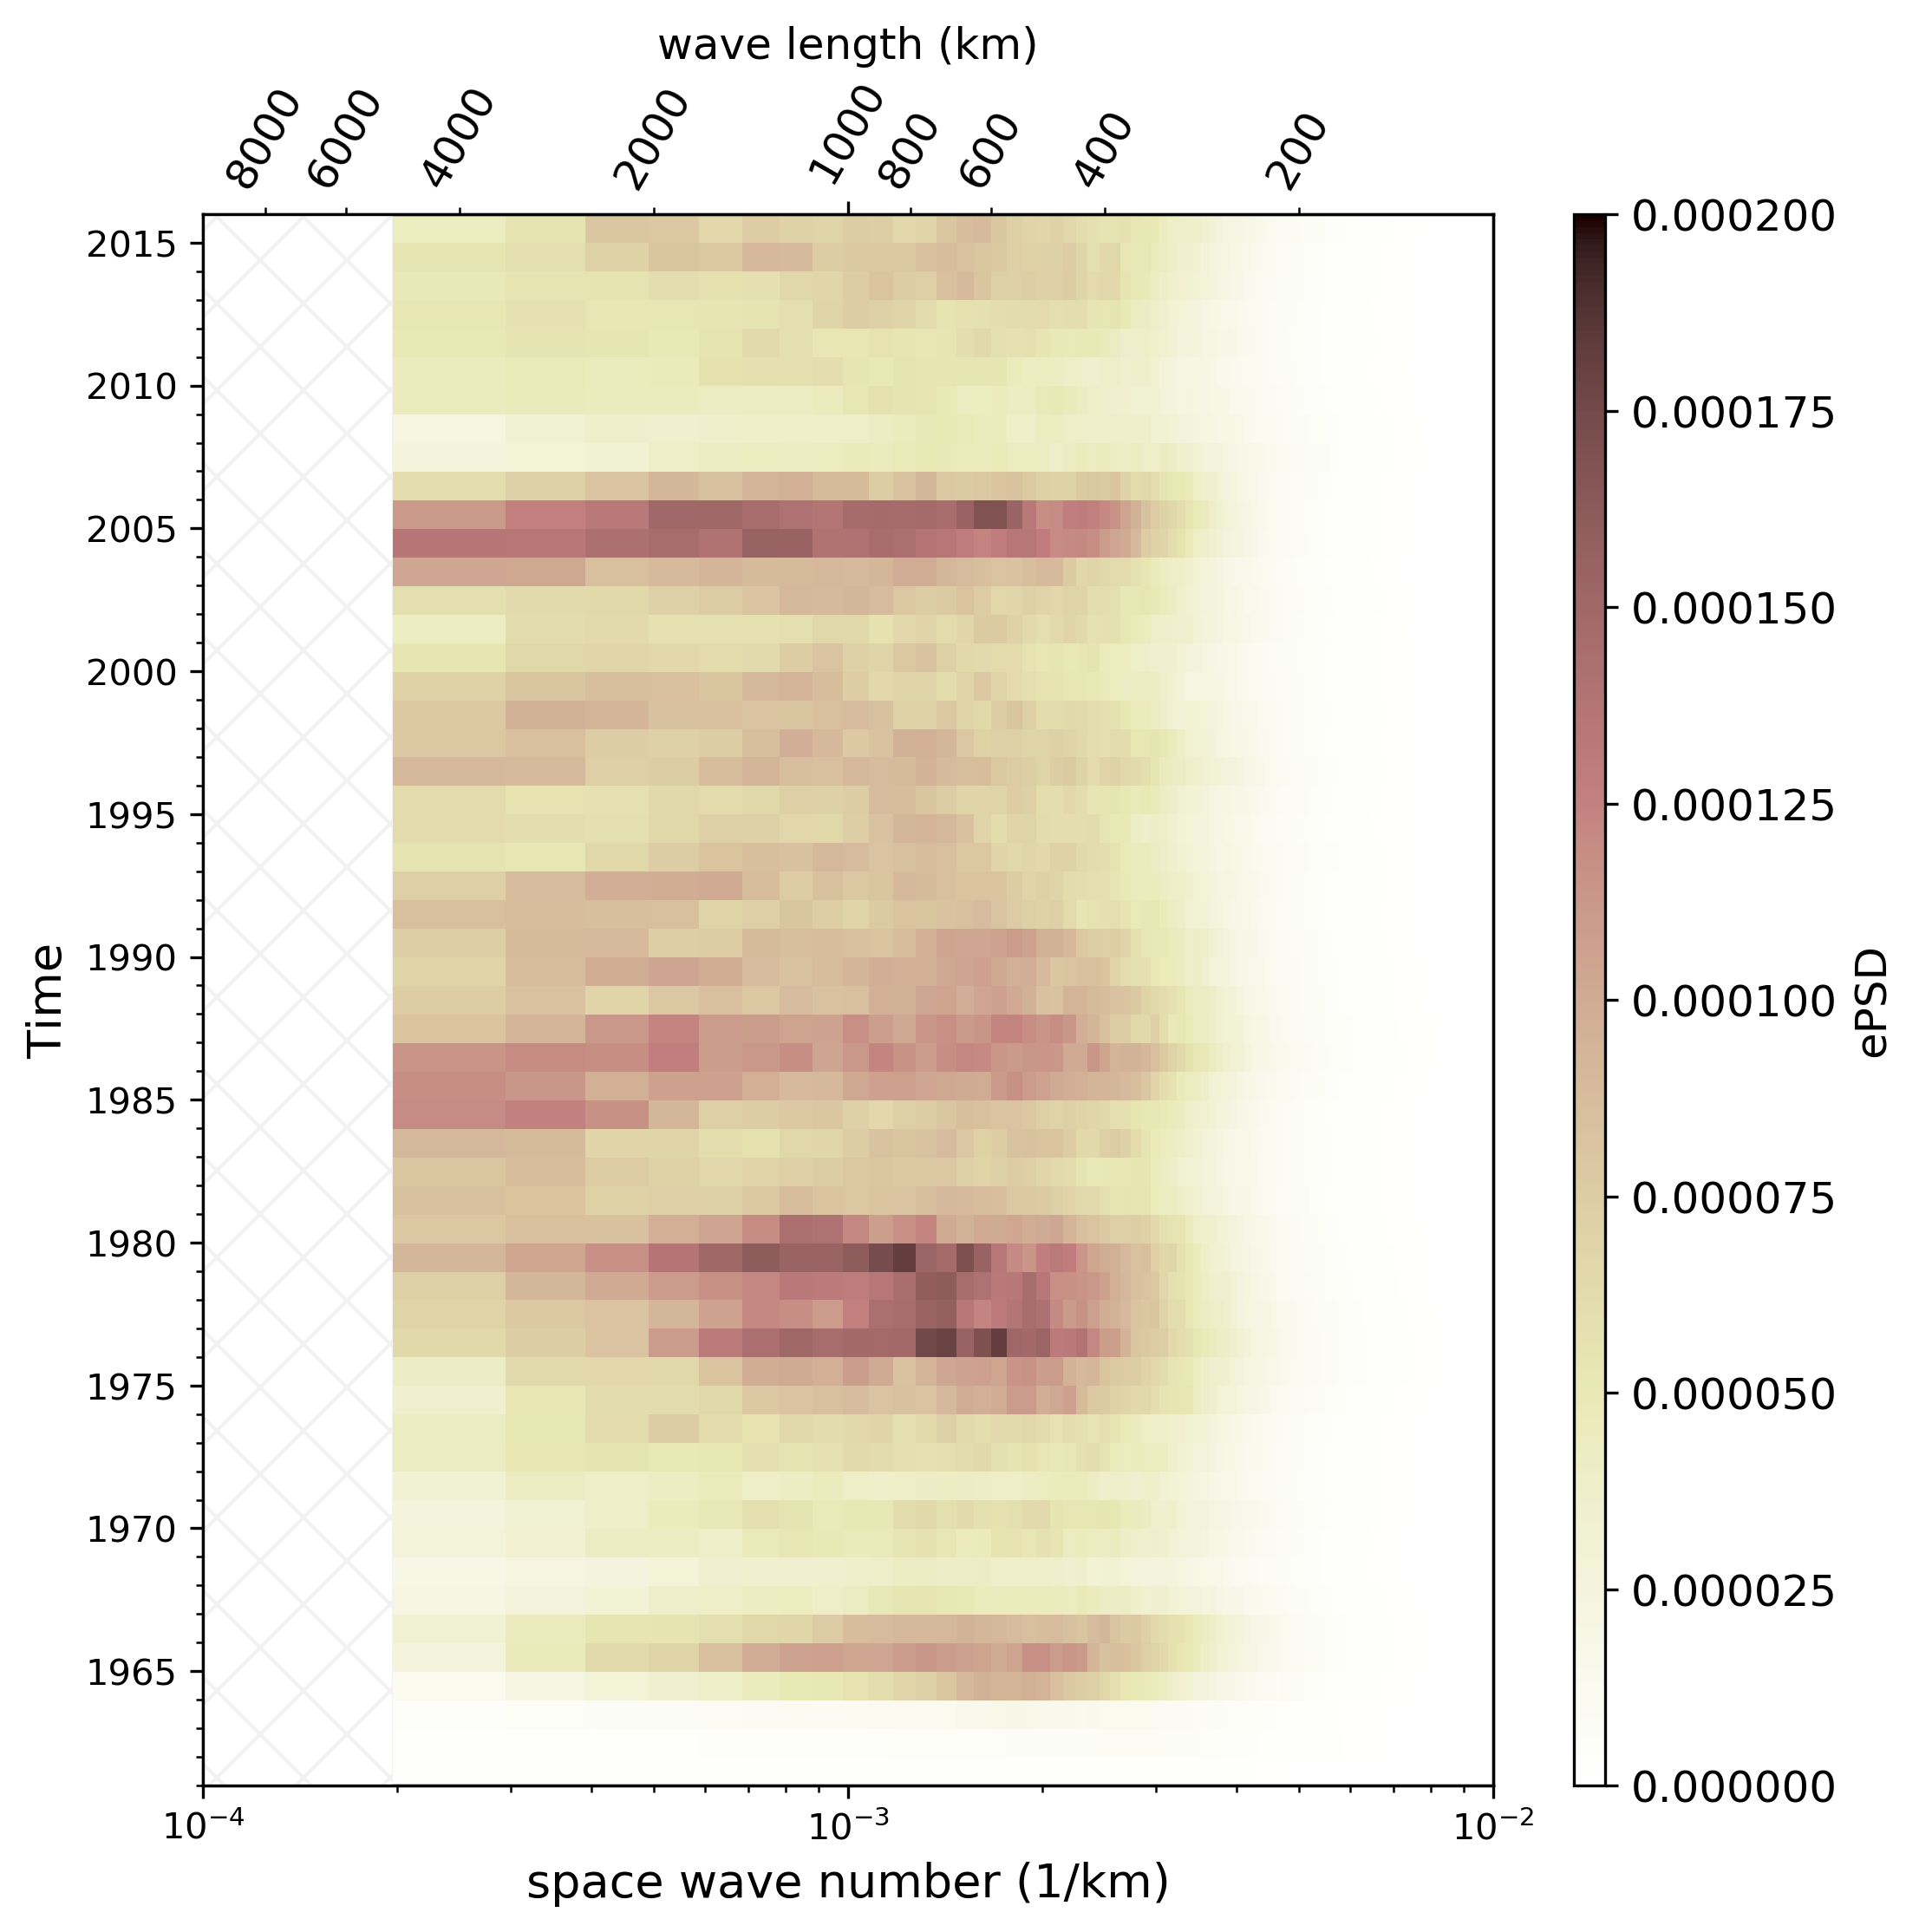

In [14]:

#-----------------------------------
# switches for various plot options
#  dates to zoom on (a plot will be made)
date1='1960-01-01'
date2='1975-12-31'

# prefix for plot name
prefix = 'INT_HMSP'

# will make a plot for each of those 3 temporal resolutions (5d is the input frequency, 3M and 1Y will require resampling (averaging) ) 
listsamp=('5d','3M', '1Y')

# color scale limits
vmin=0.
vmax = 0.0002
inc  = 0.00001

# x axis limits: (must be power exponents of 10 : xaxis from 10 ** xmin to x ** xmax )
xmin =-4
xmax=-2


#-------------------------------------
# plot
fxplots(avesp, prefix,date1,date2,vmin,vmax,inc,xmin,xmax, diro,namo,dpifig)


# __2. E-Mean__ 

## Take  ensemble mean and remove annual cycle

In [11]:
# compute ensemble mean
predat2 = SXall.mean(dim='e') 

# select data along the longtude range
dat2    = predat2.sel(SXloc=SXloc,y=0,x=slice(ilon1,ilon2)).load()


# select annual cycle for the area and smooth by sliding average
climatoselect = climato.sel(y=0,x=slice(ilon1,ilon2)).rolling(time_counter=6,center=True,min_periods=1).mean() 

# remove annual cycle from 5-d data
climarray=climatoselect.values
for iy in range(2,57):
    climarray=np.concatenate([climarray,climatoselect.values])   # make annual cycle as long as the data series 
dato = dat2 - climarray 


/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## FFT decomposition and Power Spectral Density computation
Using GS's xscale package

In [12]:
# fft decomnposition
seglen = (dato.x.size) 
foo_x_spectrum2 = xfft.fft(dato, dim='x', dx=dx.values, detrend='mean',nfft=seglen*NPADDING,tapering=True)

# compute psd from fft coeff and average over the ensemble dimension
# load data in order to be quicker in the following plot tasks
avesp2  = xfft.psd(foo_x_spectrum2).load()

## Plot the time-wavenumber figure with a loop for different options

'''
This function aims to plot the time-wavenumber diagram from the spectral data previously computed with xfft.psd().
It generates 6 plots: for the entire time period and for a zoom in time, and for each of these 2 options, the plot is made
from the initial frequency (5-day) and from resampling to 3Month and 1 year averages.
Parameters:
* avesp: spectral data to plot (from xscale package: xfft.psd() )
* xmin, xmax:  x-axis limits: (must be power exponents of 10 : xaxis from 10 ** xmin to x ** xmax )
* prefix: prefix for plot name
* date1, date2: dates of the 'zoom' in time.
* vmin, vmax, inc: shading min,max, increment.
'''

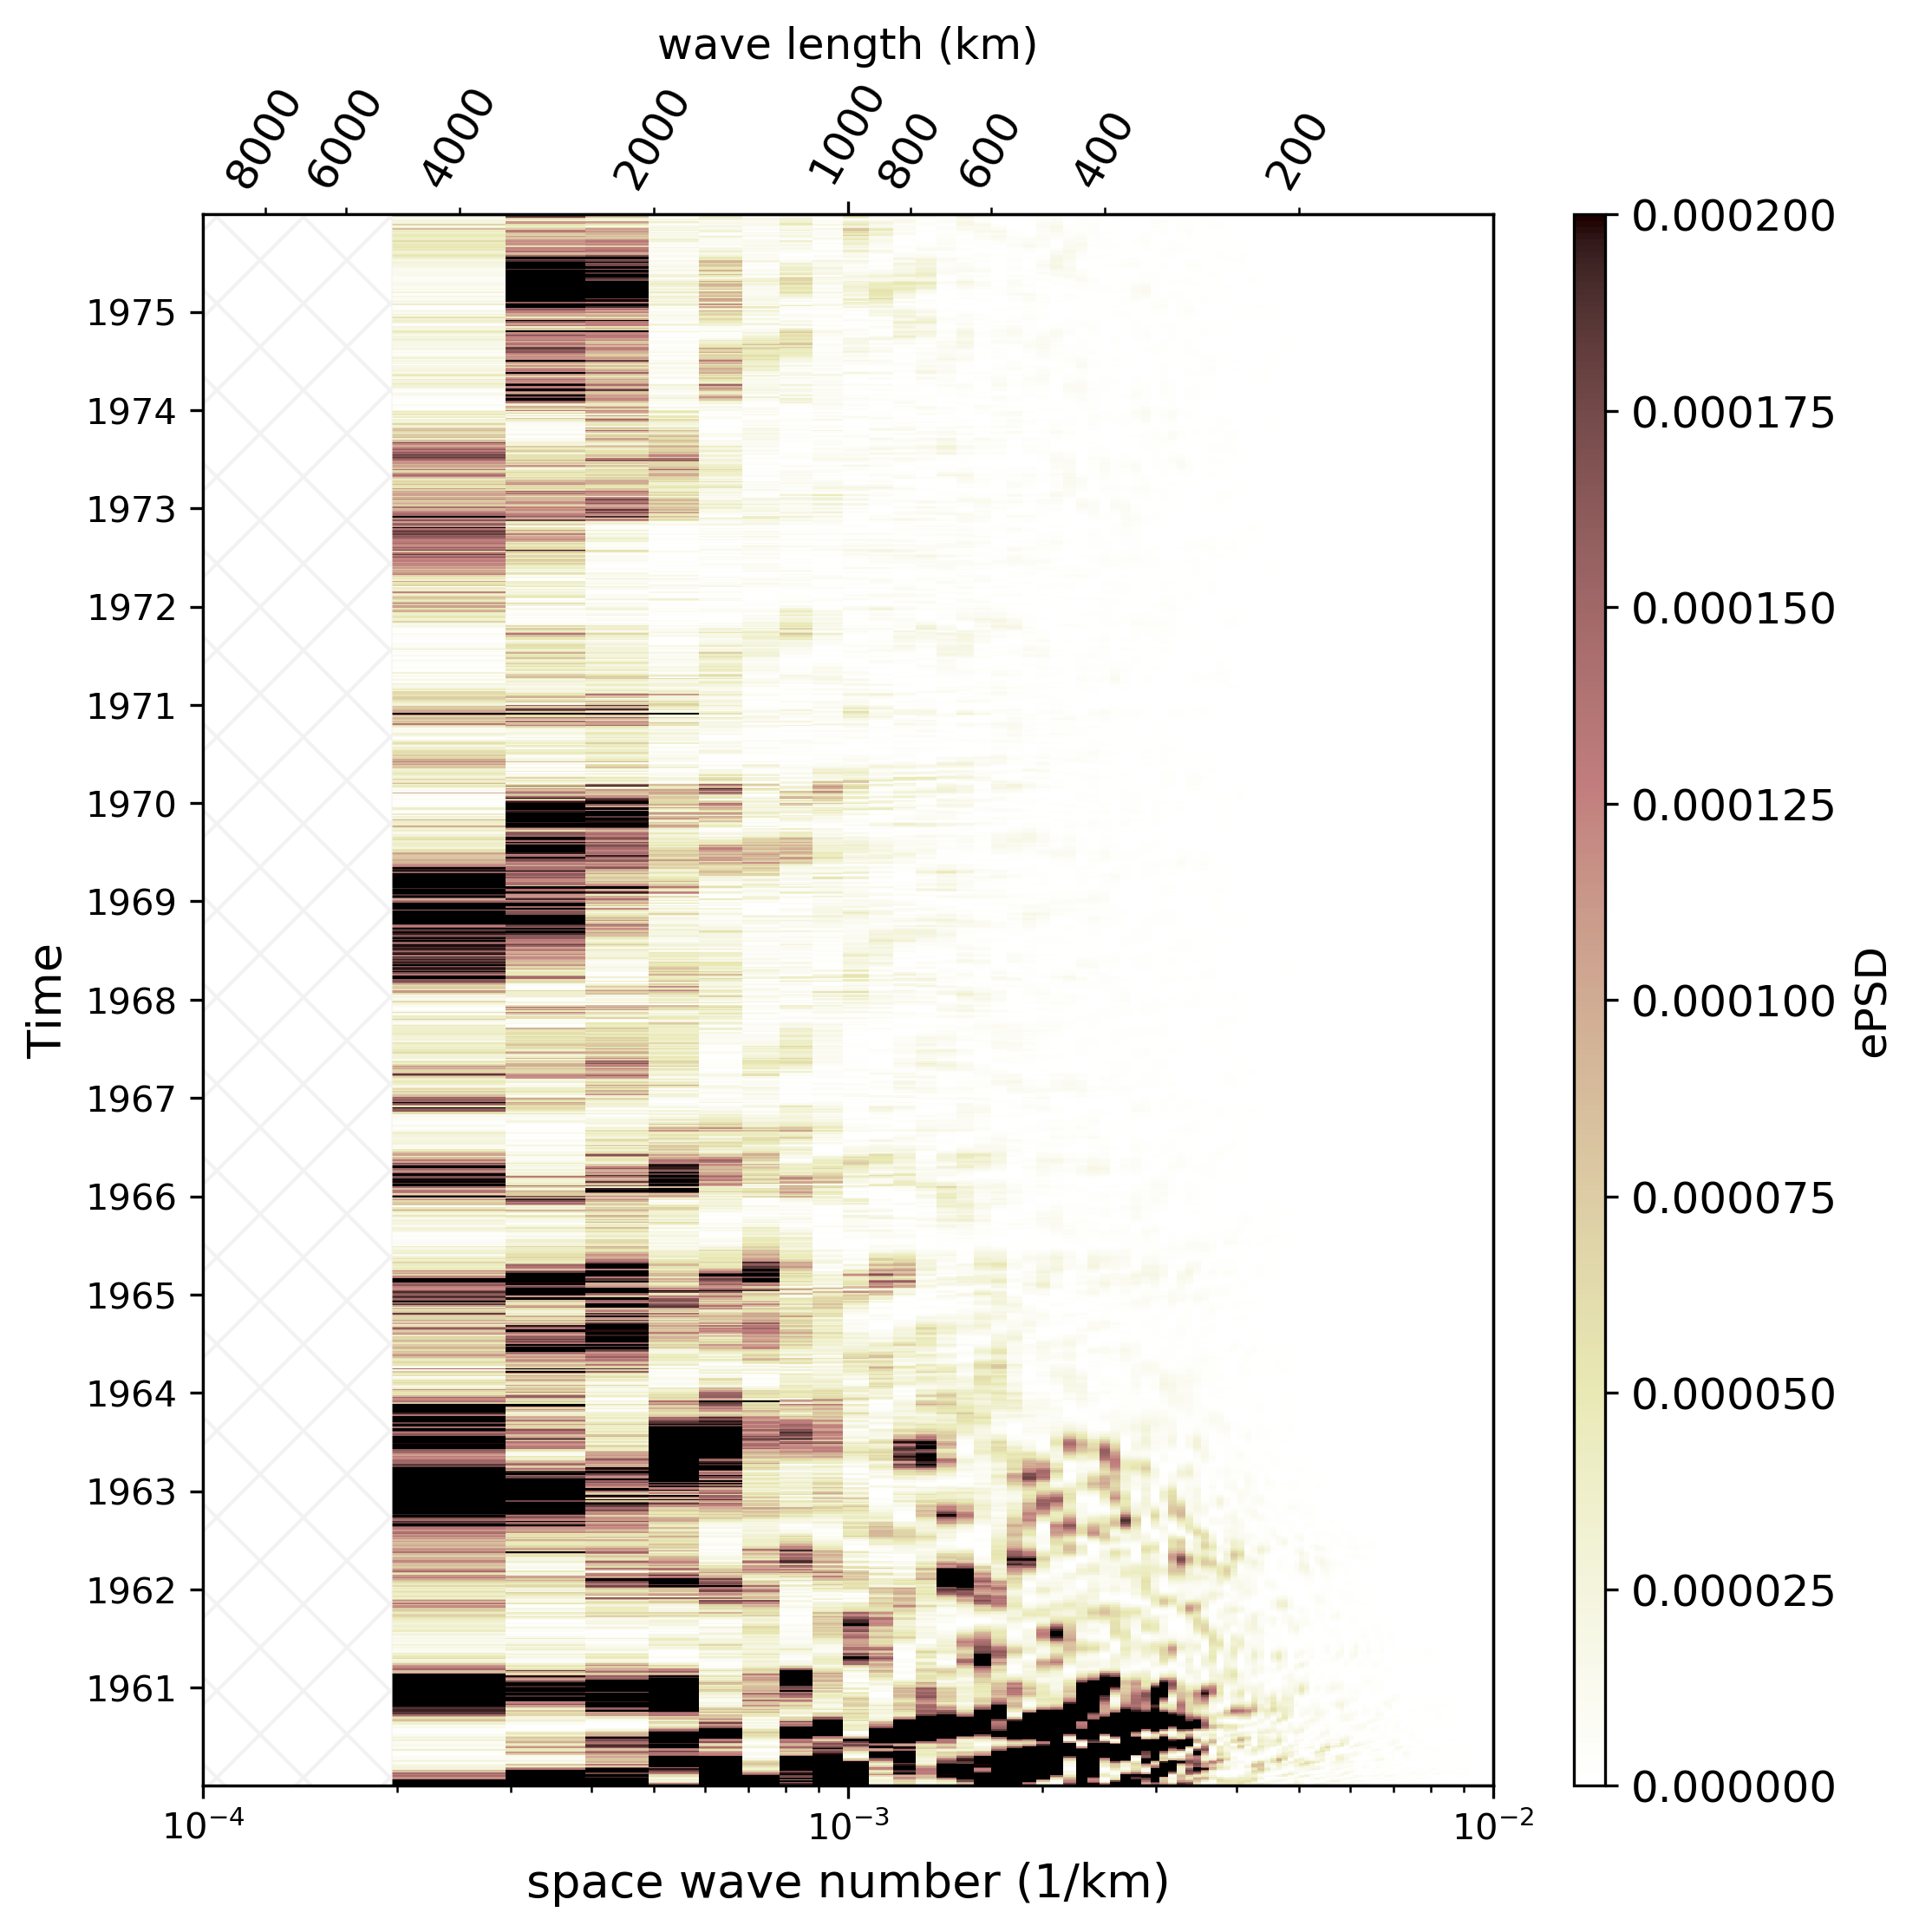

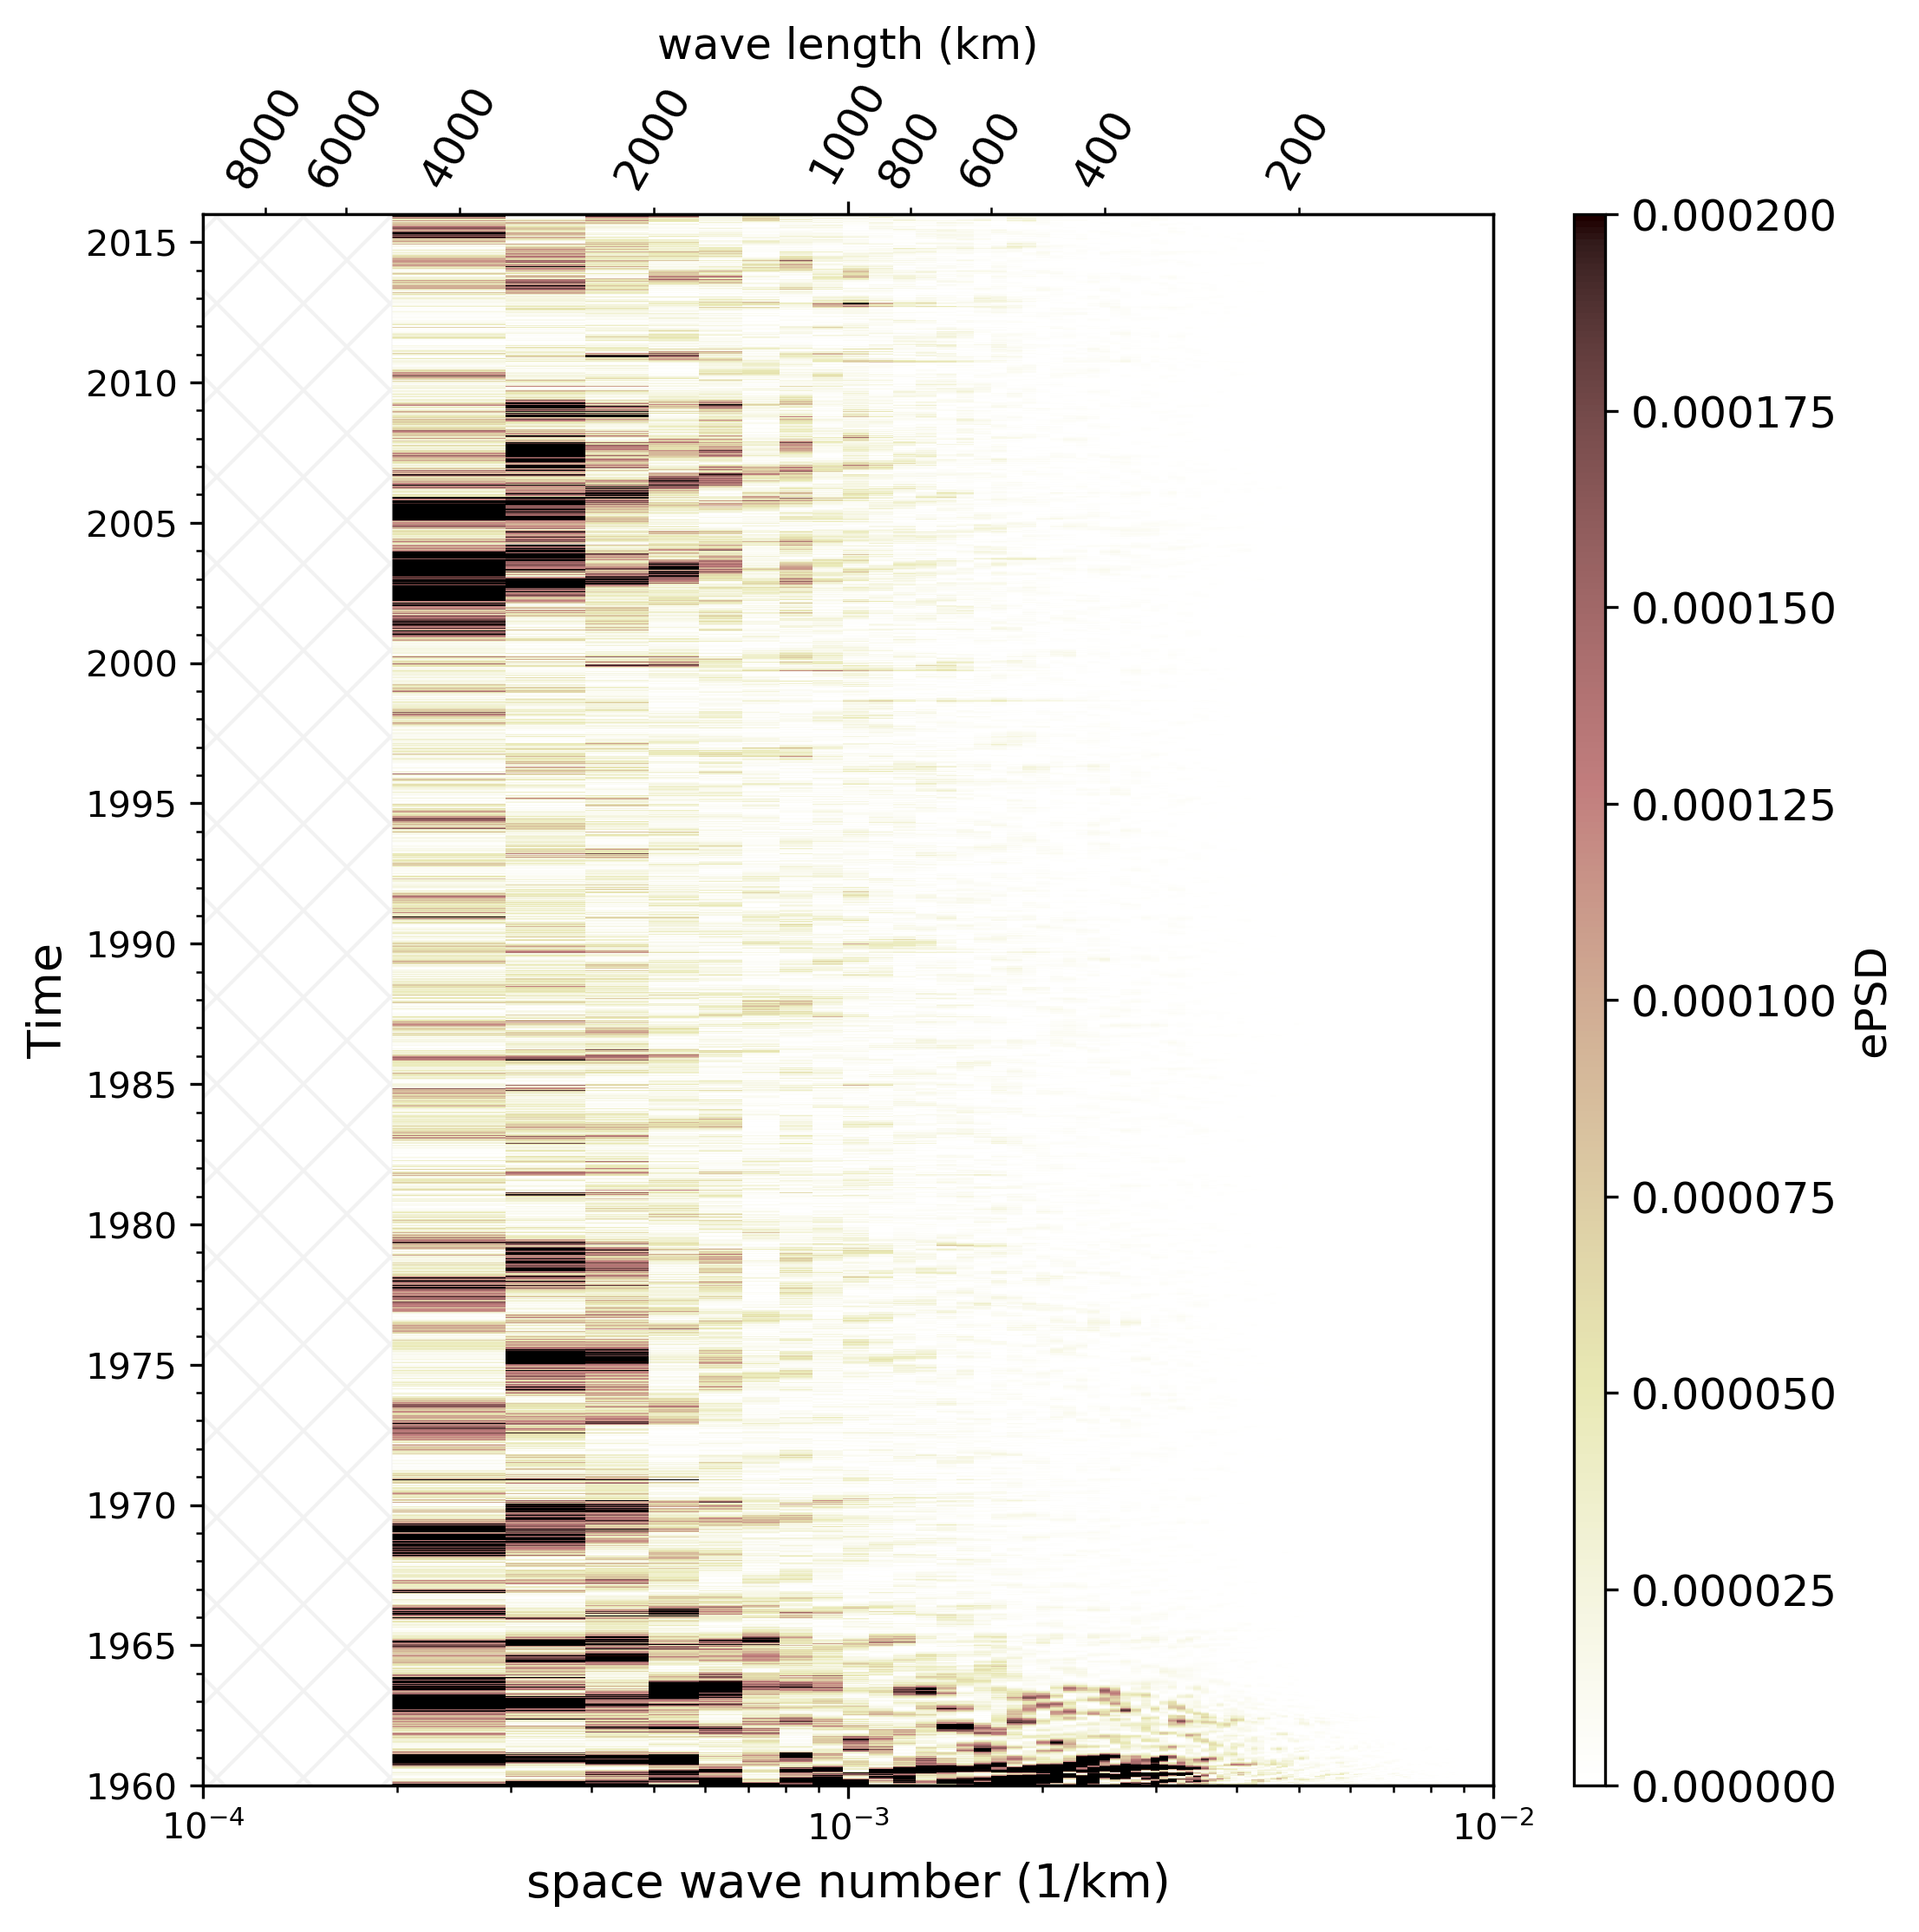

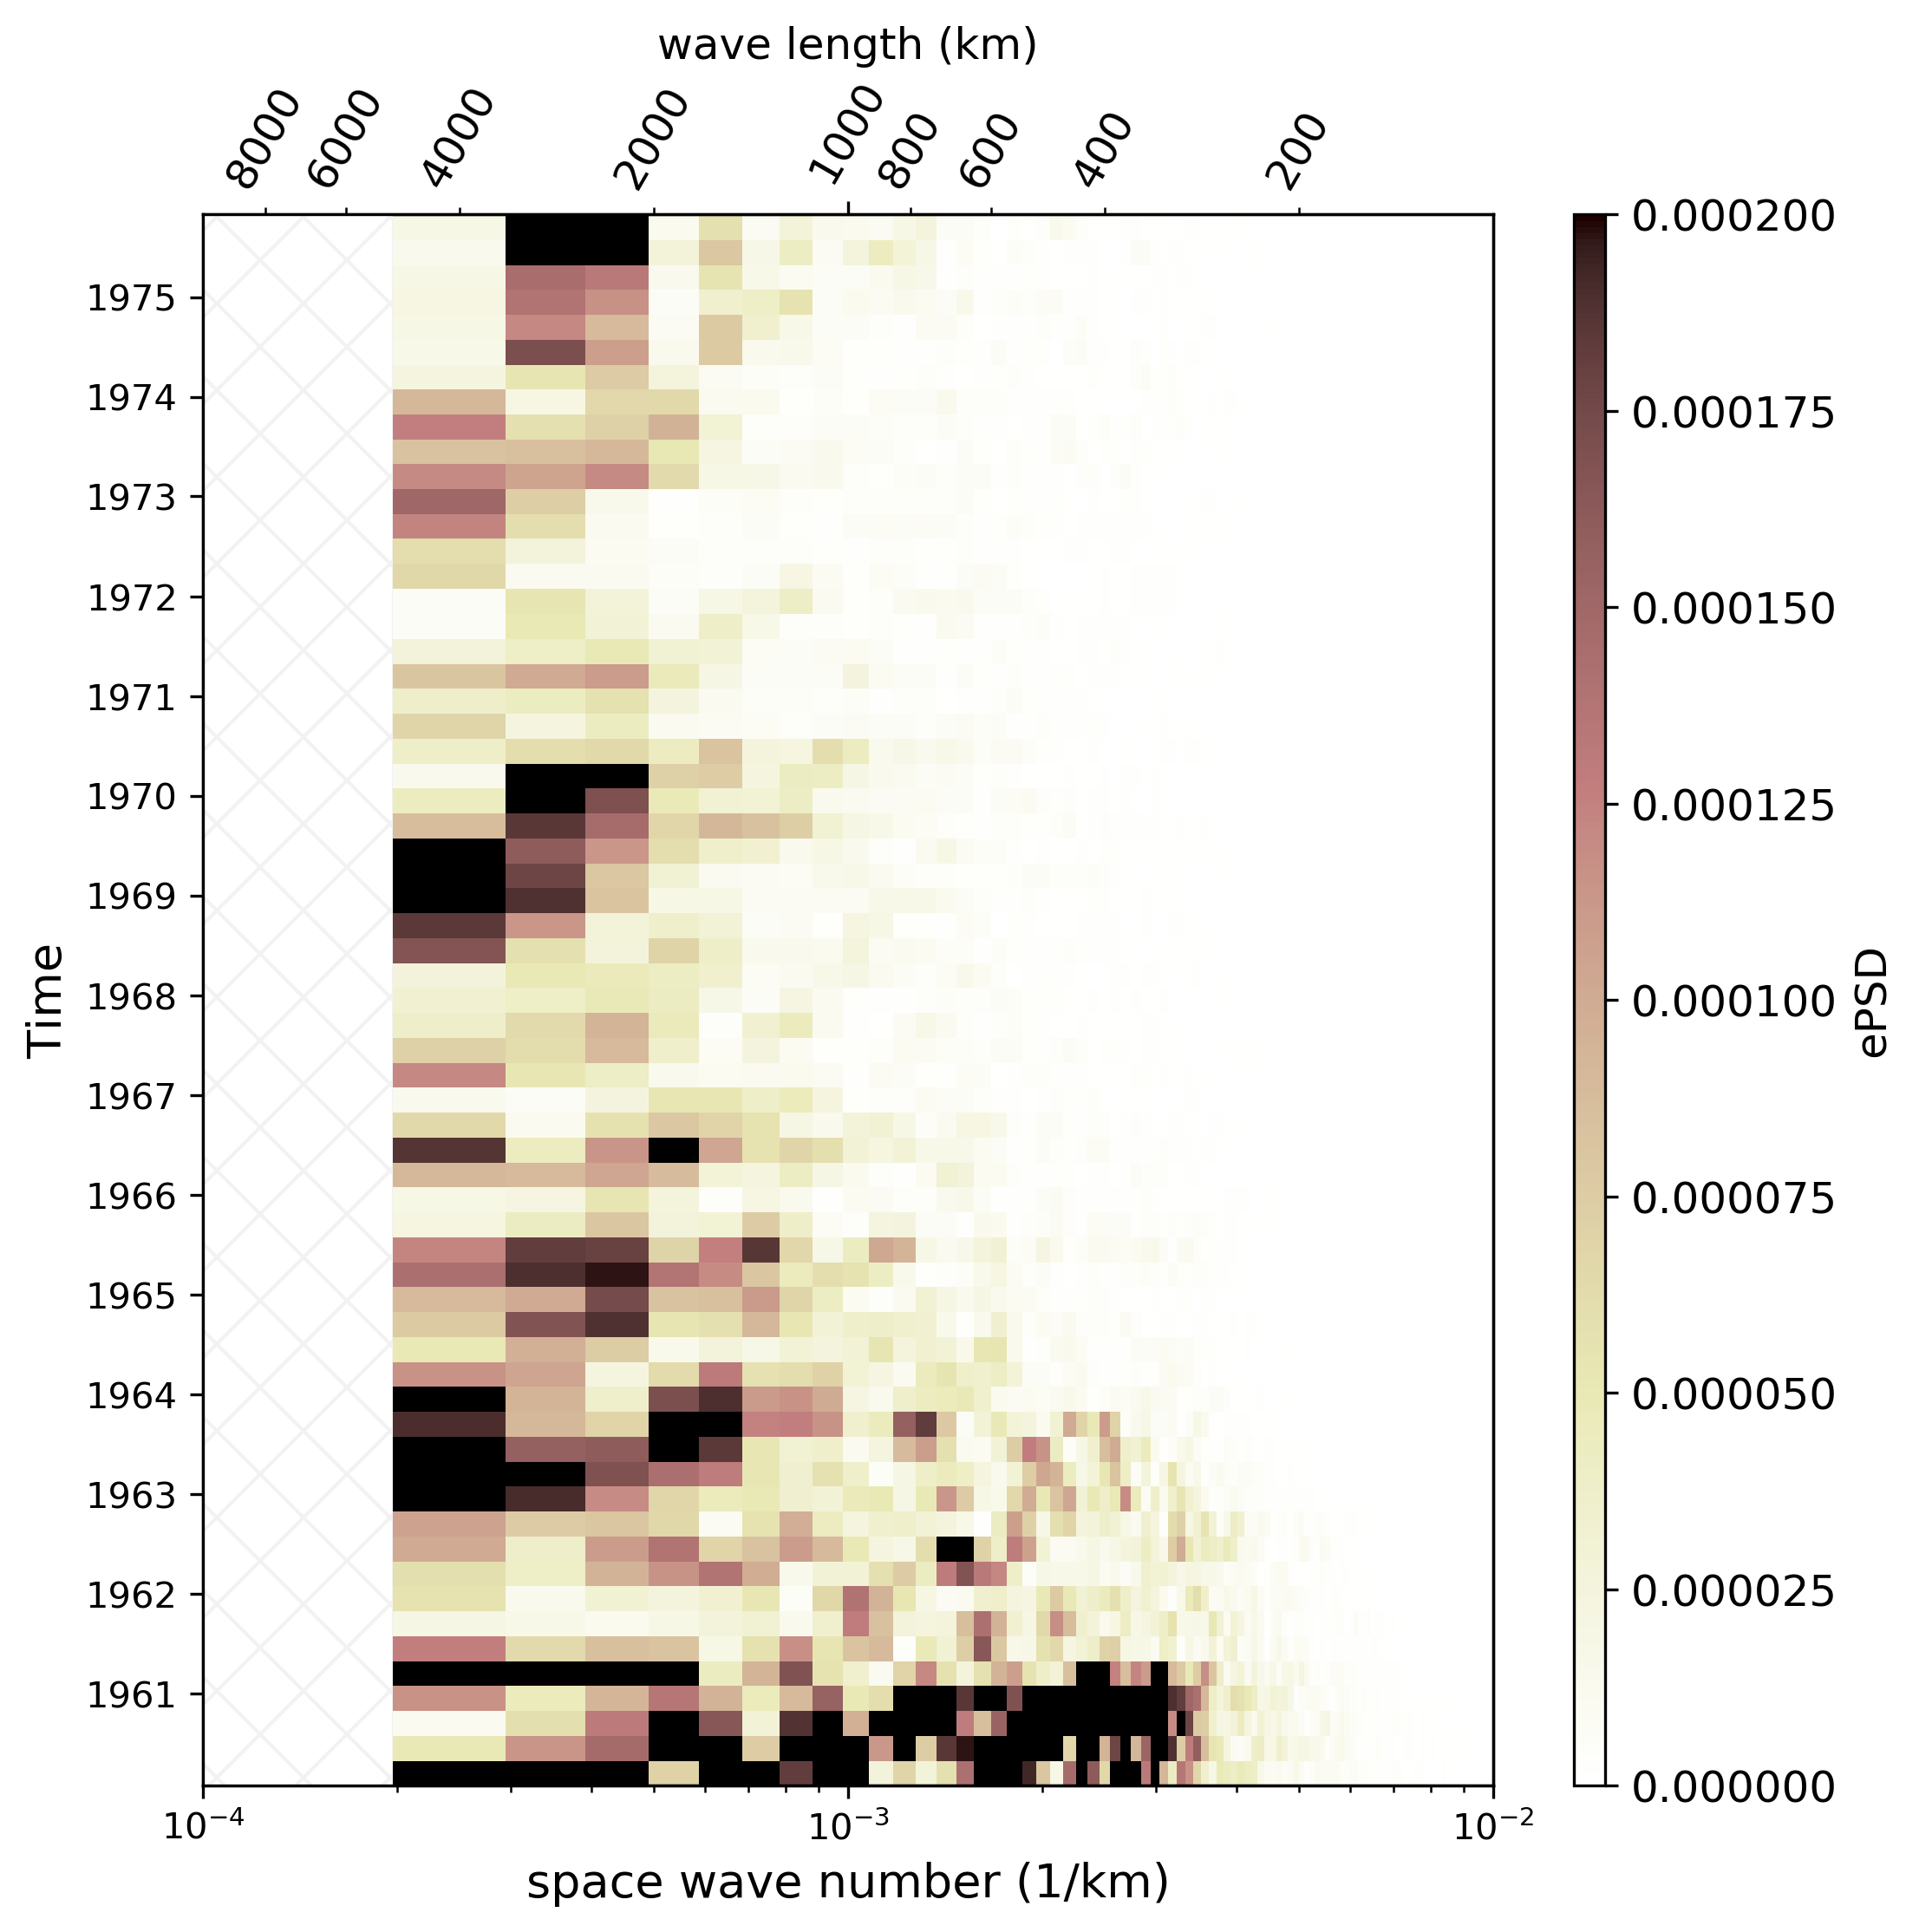

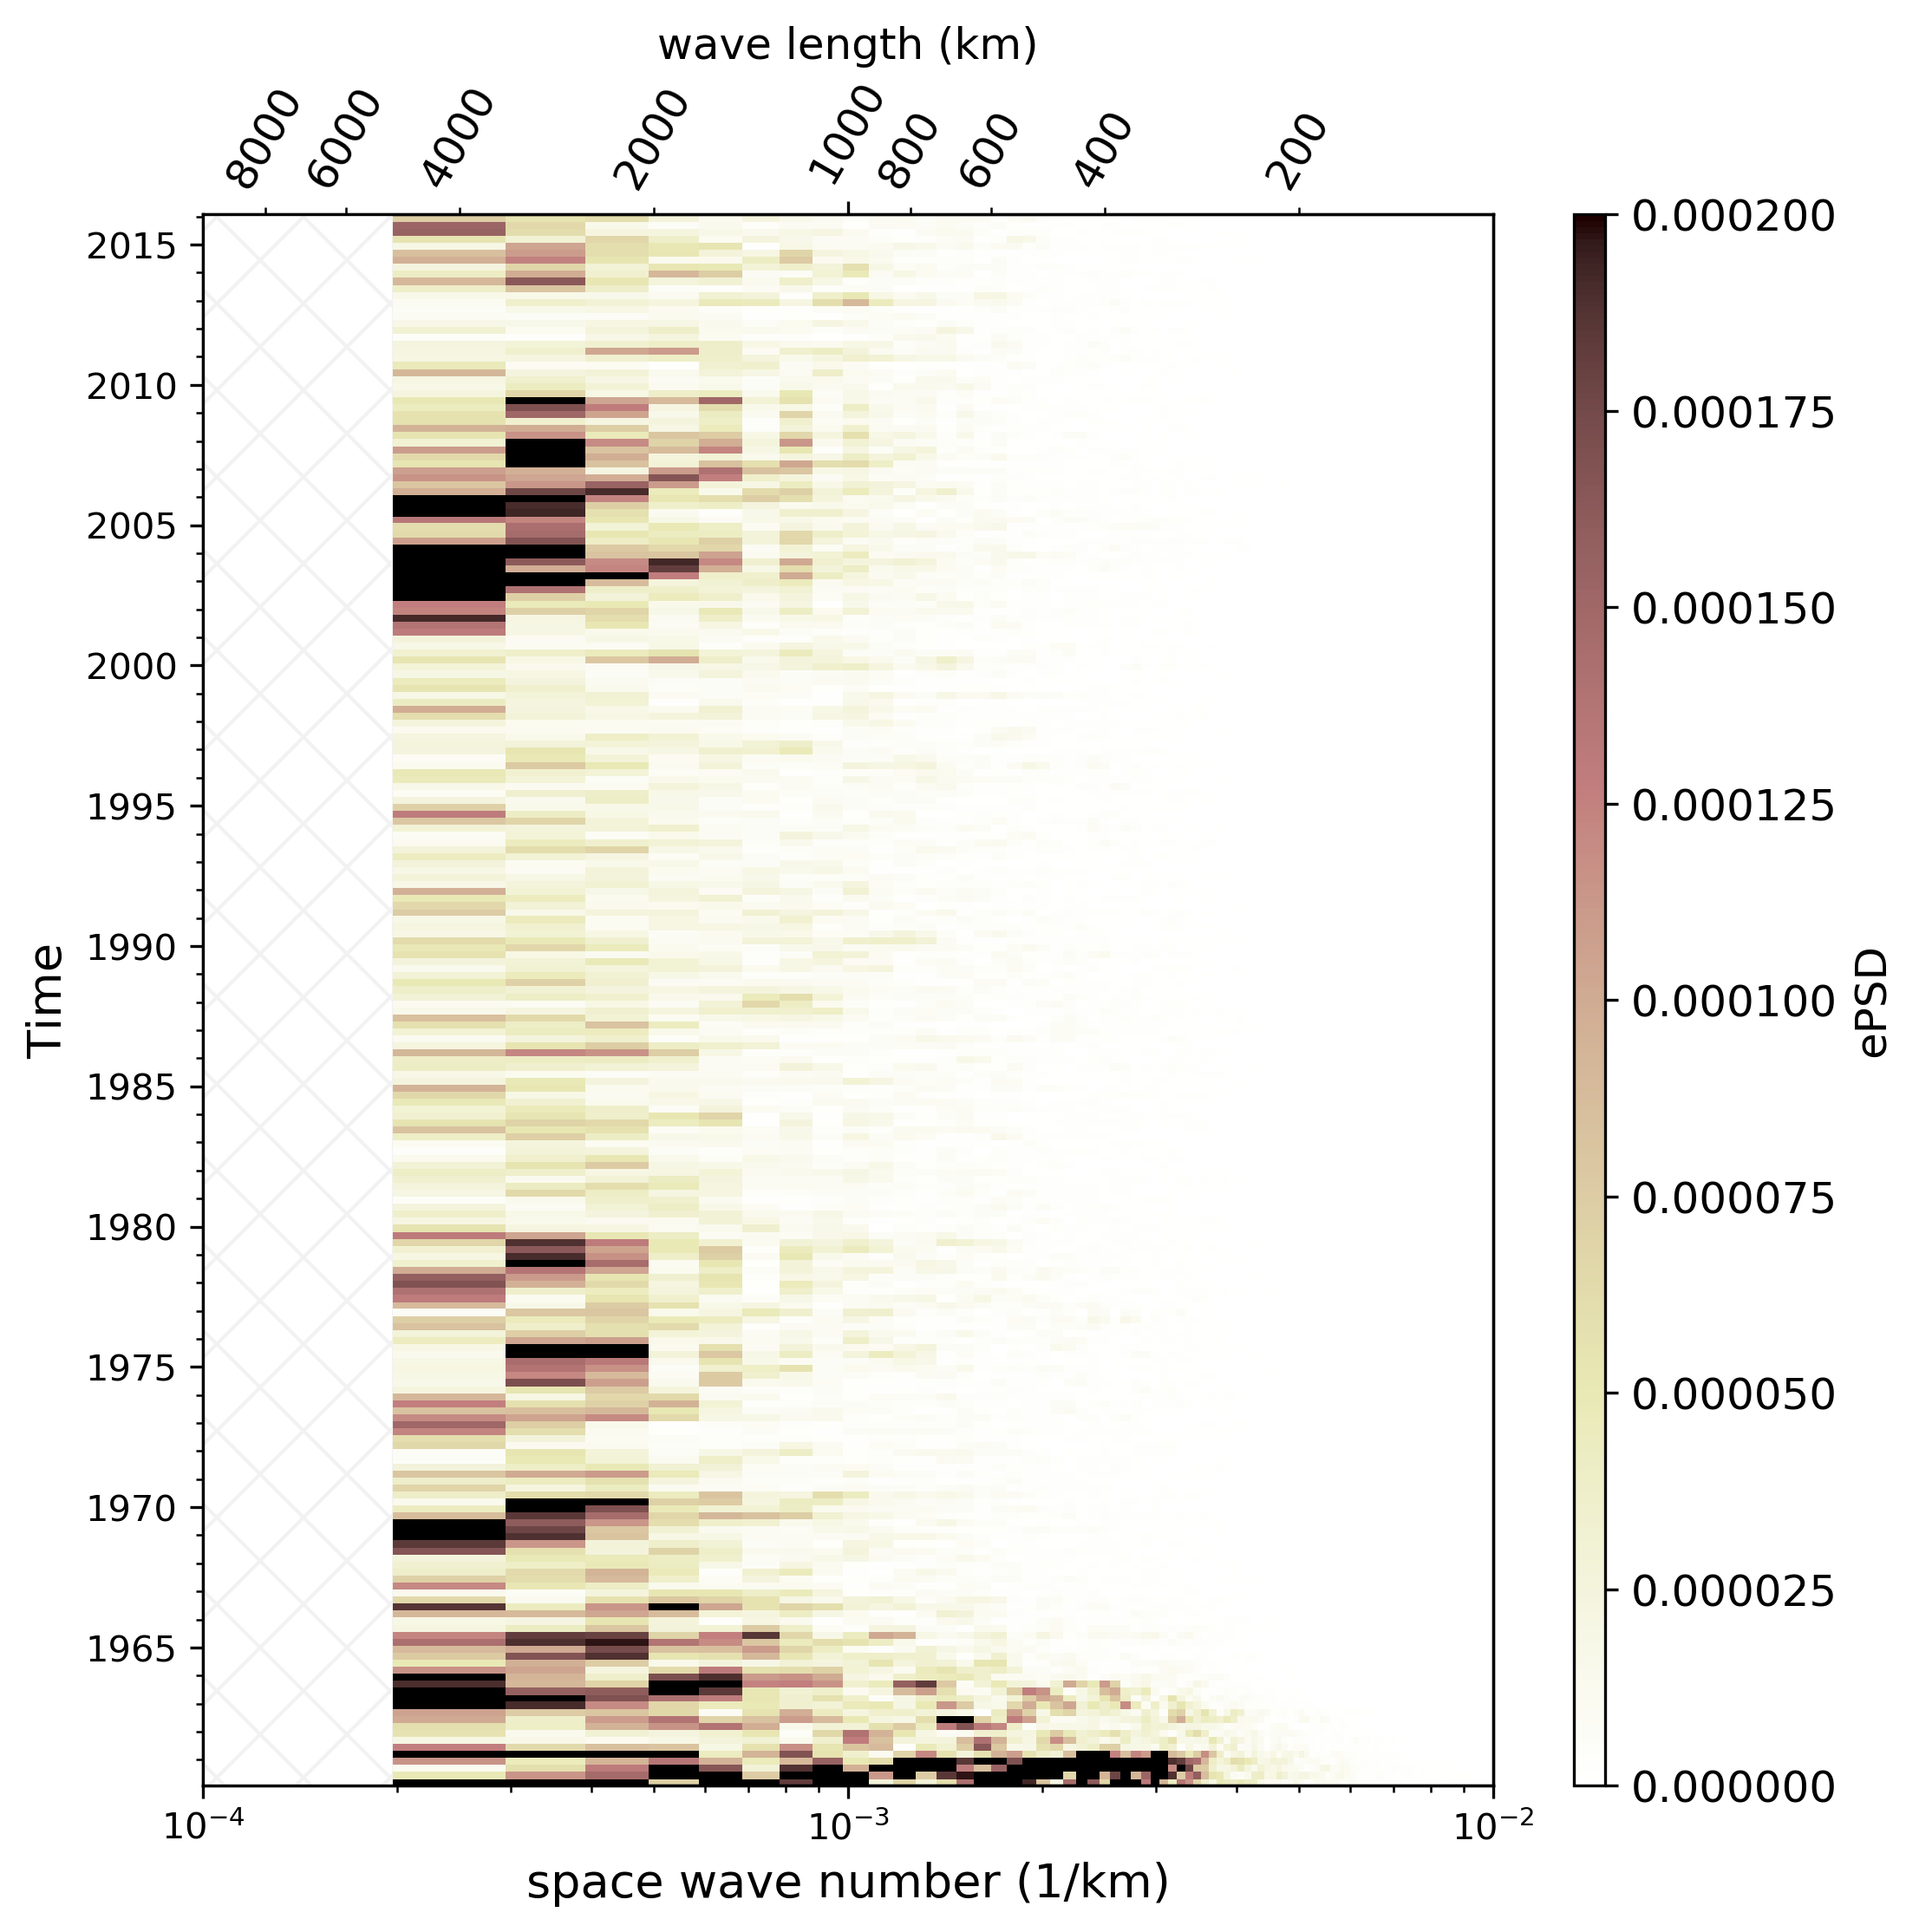

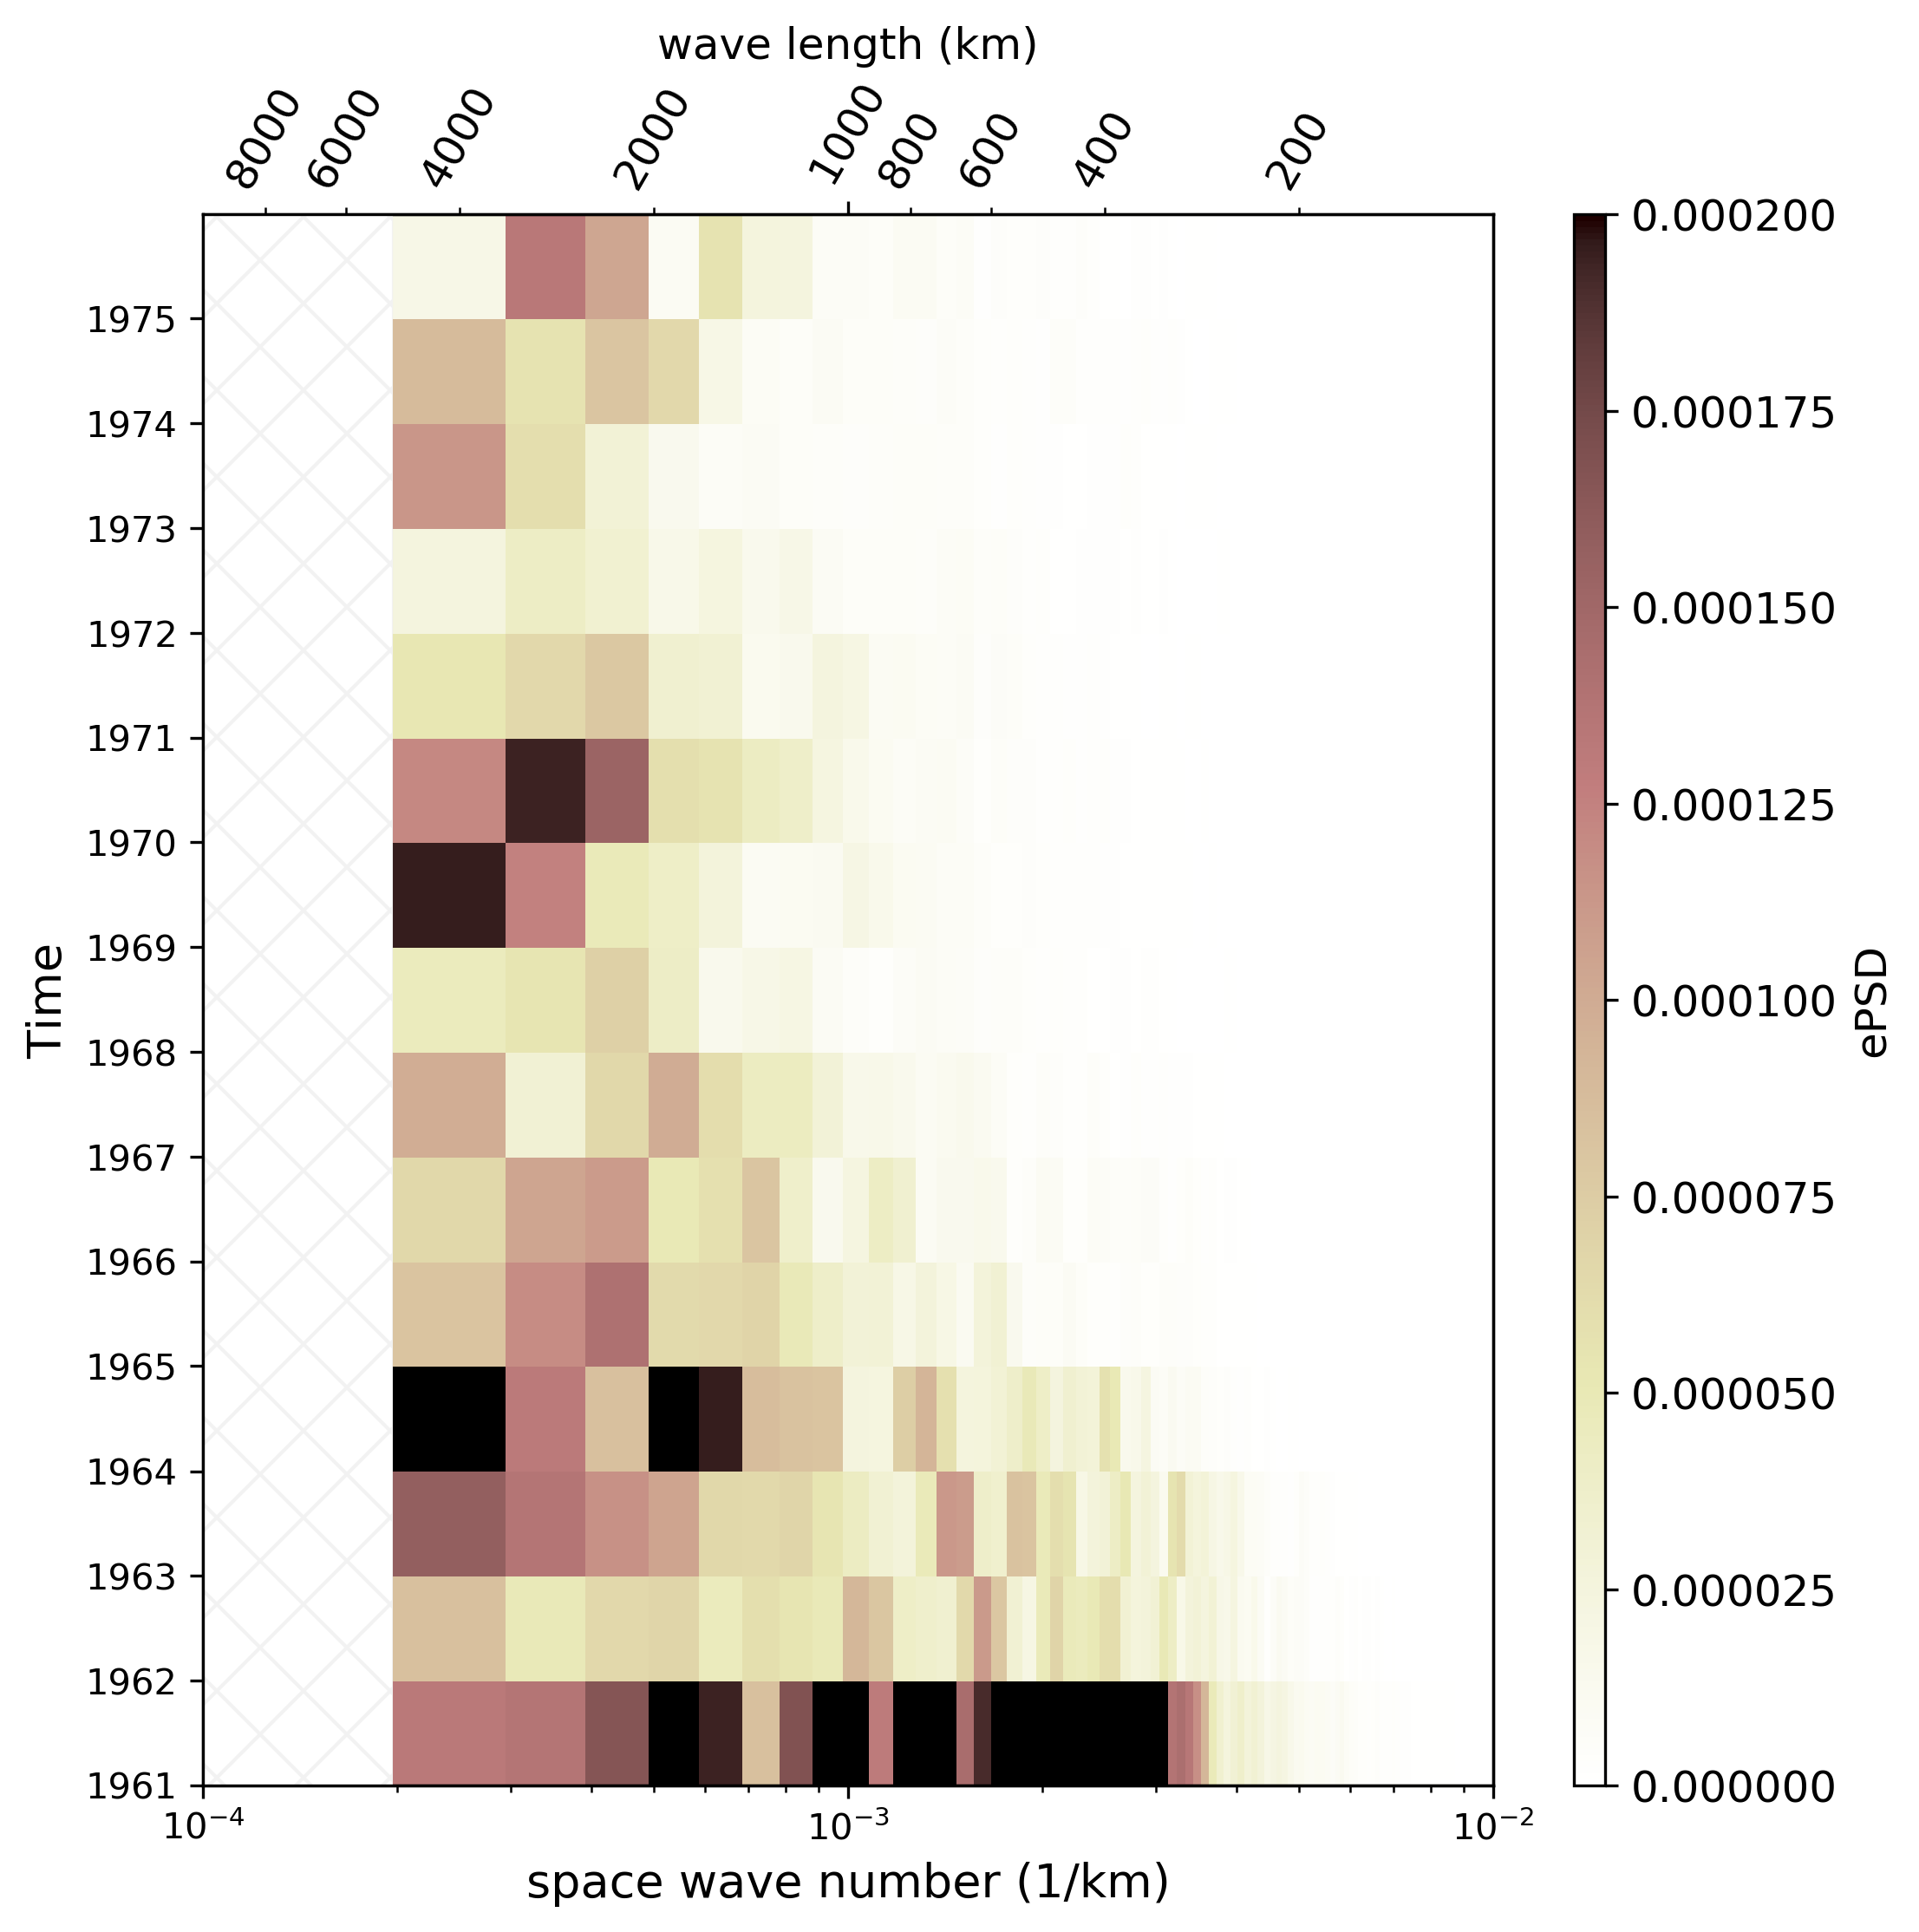

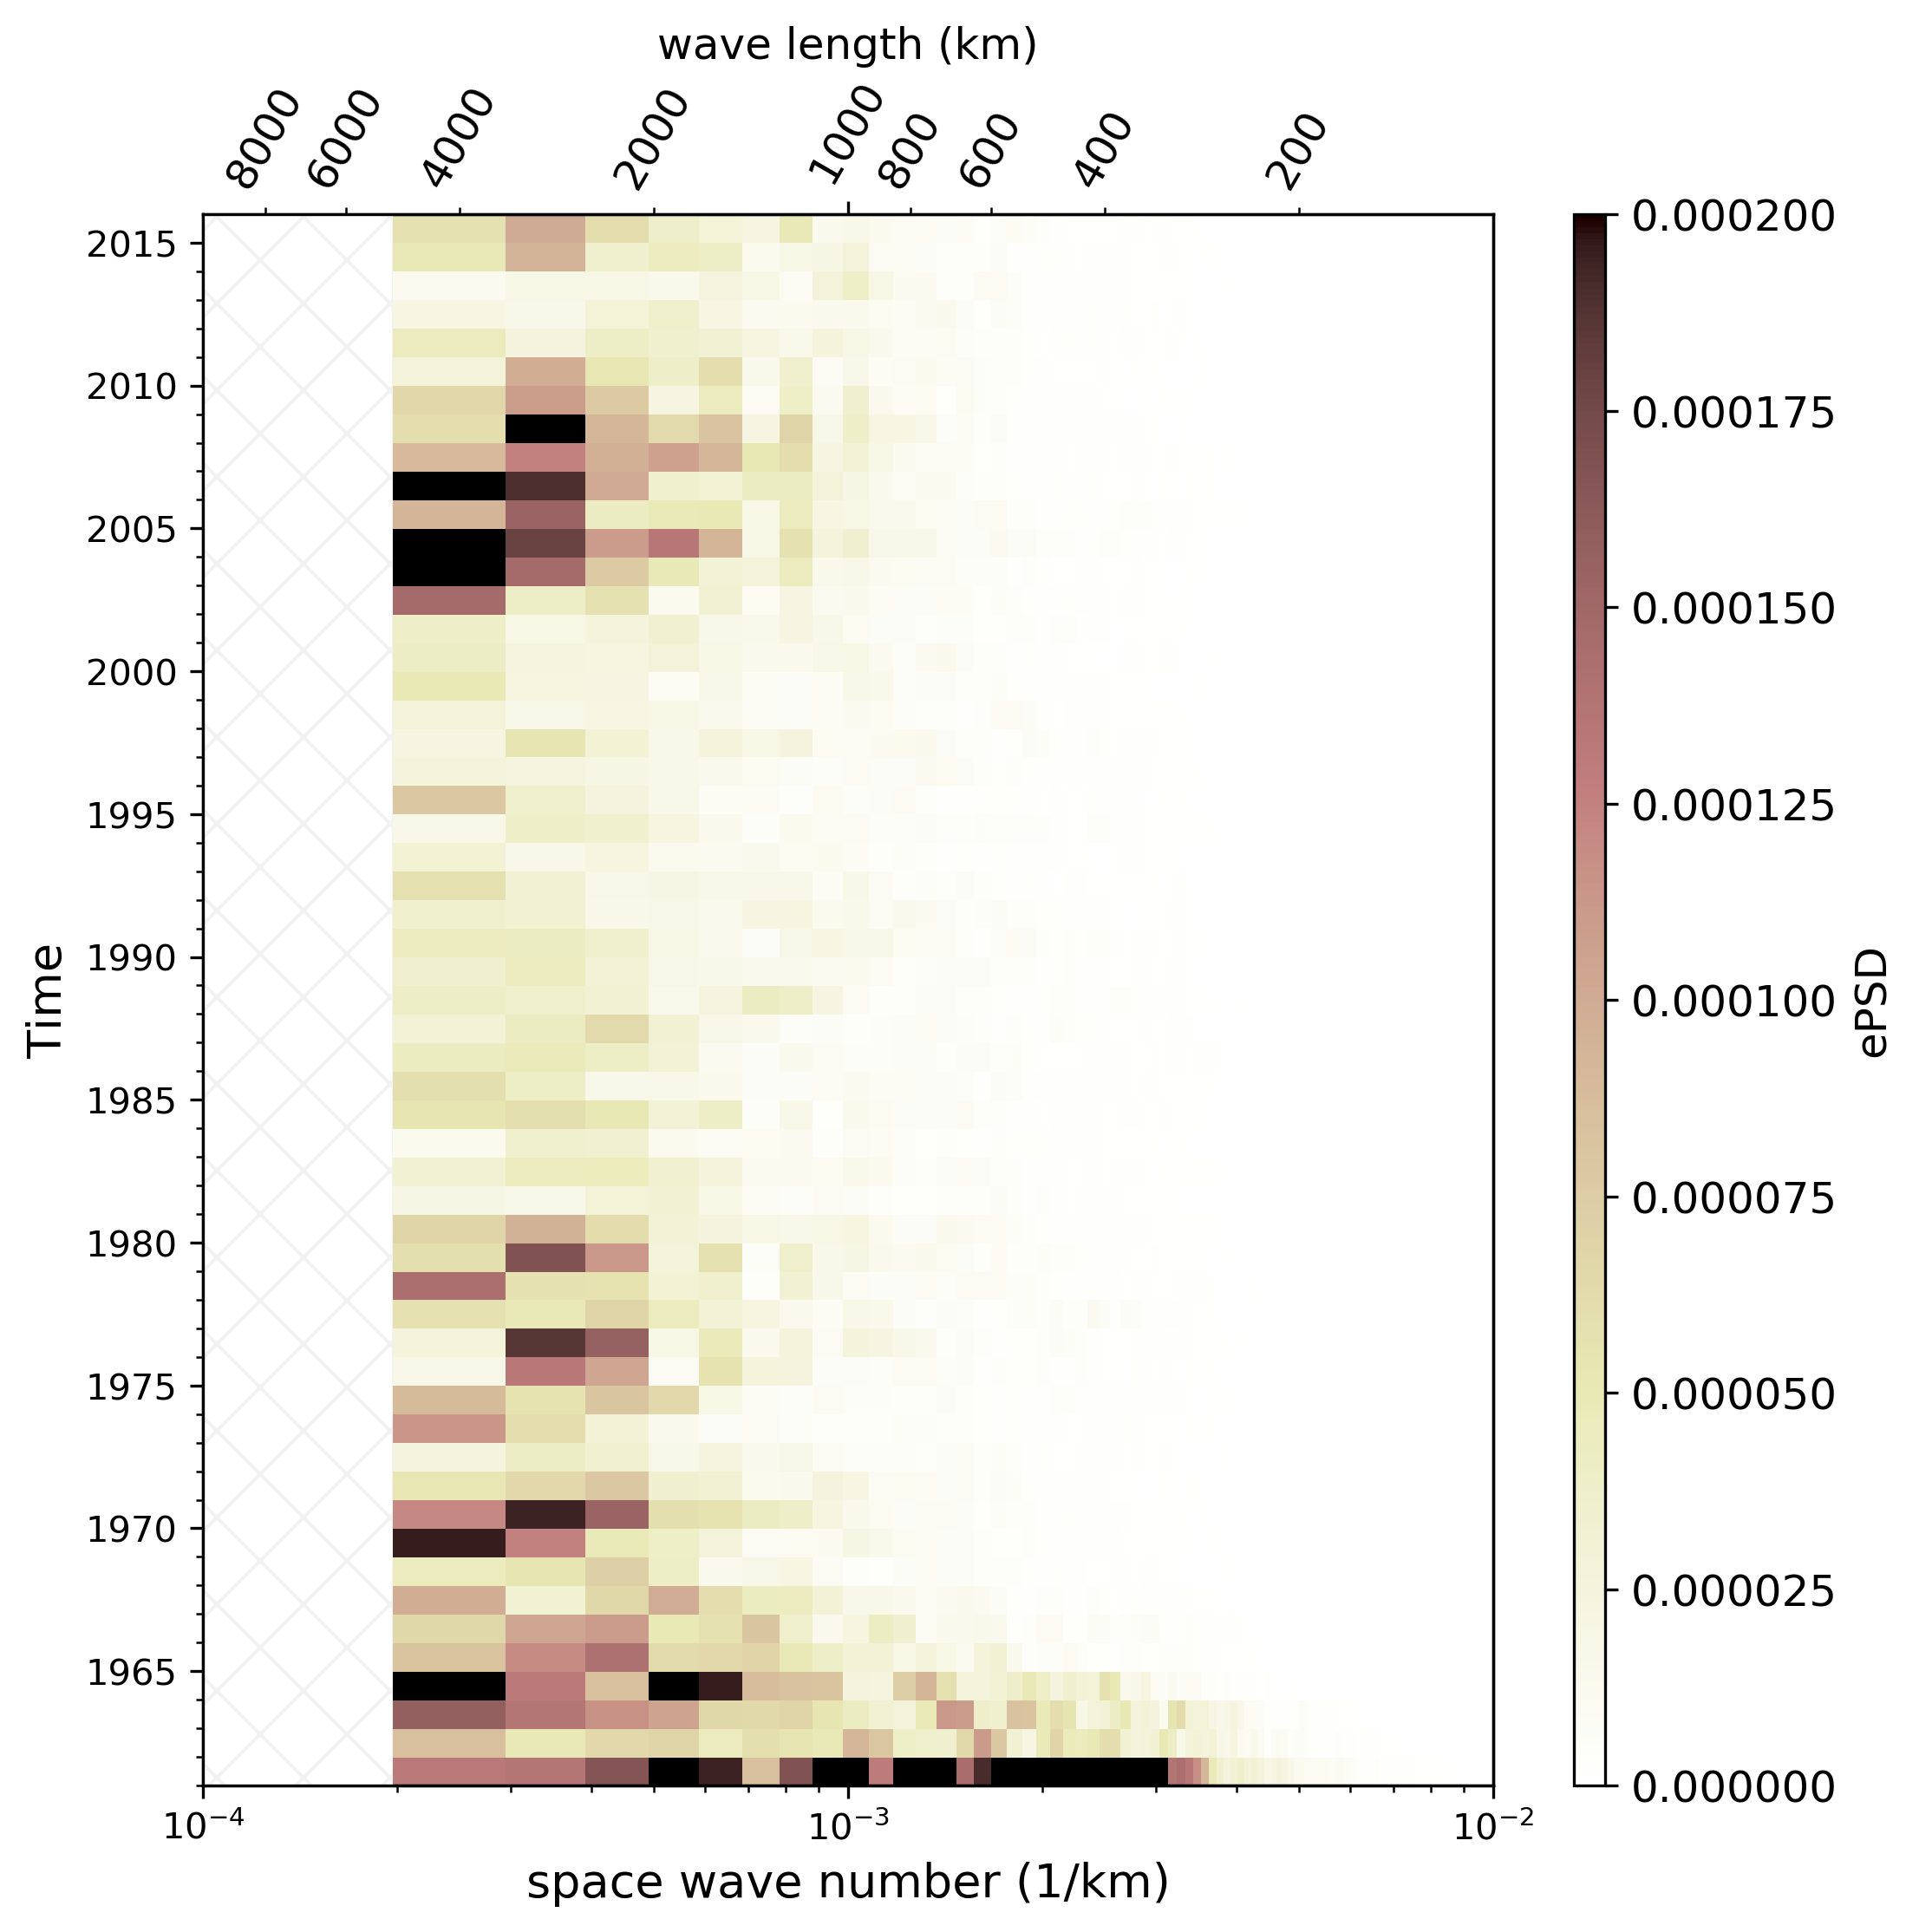

In [13]:

#-----------------------------------
# switches for various plot options
#  dates to zoom on (a plot will be made)
date1='1960-01-01'
date2='1975-12-31'

# prefix for plot name
prefix = 'EM_HMSP_'

# will make a plot for each of those 3 temporal resolutions (5d is the input frequency, 3M and 1Y will require resampling (averaging) ) 
listsamp=('5d','3M', '1Y')

# color scale limits
vmin=0.
vmax = 0.0002
inc  = 0.00001

# x axis limits: (must be power exponents of 10 : xaxis from 10 ** xmin to x ** xmax )
xmin =-4
xmax=-2


#-------------------------------------
# plot
fxplots(avesp2, prefix,date1,date2,vmin,vmax,inc,xmin,xmax, diro,namo,dpifig)